In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim

from scripts.BTK_generator import BTK_blend_generator as btk_generator
from scripts.FFT_calcs import FFT_IFFT_calc 

**Work for tomorrow:**
1. Calculate the FT of the general non-rotated equation by hand and then code it up to see if it matchs what I get from `fft.fft2` (This is to see if there is something wrong with the basic form of the general equation for the rotated general equation).
2. Fix the equation for the analytical FT of the rotated equation
3. See how the shear and magnification are parameterized for $C$ or $C^{-1}$ (how is the spinor defined)
4. Incorporate shear into the rotated gaussian
5. See how noise affects the FT of these gaussians.

# 0. Goal of this Notebook

David said it would be good to better understand what was happening with the FT, so he suggested writing in code & by hand what the FT of a round 2D gaussian and an elliptical 2D gaussian is.

This notebook is the code portion of this task. 

**Work for next time:**
1. Might be good to make my own function for 2D gaussian that has the ability to create an elliptical gaussian. Do the FT of this, so I know what to expect
2. Compare what I got in (1.) with the answers by-hand
3. Do what I did in (1.), but using `GalSim`. I already have the `Galsim` 2D round gaussian, but I'm unsure what exactly David wanted from me when he was representing the elliptical galaxy in terms of $\sigma_1, \sigma_2, \rho$. I know I can represent it in terms of the reduced shear components $g_1, g_2, \sigma$ as in the photo ($\sigma \rightarrow e \hspace{02mm} \text{in `galsim`}$). And I know `GalSim` has this functionality, so would be good to do it in both ways potentially.

**NOTE:** This [wiki](https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Measures_of_ellipticity) page may be useful for understanding exactly what is happening/how shear is defined. But note that the `galsim` implementation of shear is different than is used in papers. For the version of shear that changes the shape of the object we want to use `lens` in `GalSim`.

# 1. Gaussians "by-hand"

In [2]:
def gauss2D(x0=0,
            y0=0,
            sigma_x=1.0,
            sigma_y=1.0,
            A=1,
            N=128):
    '''Calculate the values of an unrotated/unstretched Gauss function given positions
    in x and y in a mesh grid.
    
    Args:
    -----
        x: np.ndarray
            Matrix of the x-coordinates that make up the x-coordinates of each point in 
            the meshgrid. 
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        y: np.ndarray
            Matrix of the y-coordinates that make up the y-coordinates of each point in 
            the meshgrid.
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
            
            
    Returns:
    --------
        gauss: np.ndarray
            The array containing the gaussian function evaluated at each point
            in the meshgrid. I.e. returns the image of the Gaussian.
    '''
    x = np.linspace(-10,10,N)
    y = np.linspace(-10,10,N)
    Xg, Yg = np.meshgrid(x, y)

    gauss = A*np.exp(-(Xg-x0)**2/(2*sigma_x**2) -(Yg-y0)**2/(2*sigma_y**2))
    return gauss



def FT_by_hand(img=None,
               x0=0,
               y0=0,
               sigma_x=1.0,
               sigma_y=1.0,
               A=1,
               N=128,
               FFT=True):
    """
    Function that computes the FT via the DFT matrix. This is not optimal,
    one should use the FFT algorithm to compute the DFT, but for learning purposes
    we use this to better understand the FT.
    
    Args:
    -----
    
    Returns:
    -------
    """
    # Create Gaussian
    gauss = gauss2D(x0=x0,
                    y0=y0,
                    sigma_x=sigma_x,
                    sigma_y=sigma_y,
                    A=A)

    #DFT matrix calc
    n=128
    w = np.exp(-1j * 2 * np.pi / n)
    J, K = np.meshgrid(np.arange(n), np.arange(n))
    DFT_mat = np.power(w, J*K)
    
    if FFT==True:
        # Create empty arrays for use in DFT calc
        DFT_y = np.zeros((n,n), dtype=np.complex128)
        DFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            DFT_y[i,:] += np.dot(DFT_mat, gauss[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            DFT[:,j] += np.dot(DFT_mat, DFT_y[:,j])

        # Center the lowest frequencies in the center of the image
        DFT = np.fft.fftshift(DFT)
        
        return gauss, DFT
        
    else:
        
        w = np.exp(1j * 2 * np.pi / n)
        J, K = np.meshgrid(np.arange(n), np.arange(n))
        IDFT_mat = np.power(w, J*K)
        
        # Create empty arrays for use in DFT calc
        IDFT_y = np.zeros((n,n), dtype=np.complex128)
        IDFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            IDFT_y[i,:] += np.dot(IDFT_mat, img[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            IDFT[:,j] += np.dot(IDFT_mat, IDFT_y[:,j])

        # Center the lowest frequencies in the center of the image
#         IDFT = np.fft.fftshift(IDFT)   
        return IDFT

## 1.1 Round/Elliptical Gaussians FT

[Bruntons notebook](https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC06_1_2DFFT.ipynb)

**FT of small round gaussian $\rightarrow$ large FT Gaussian**

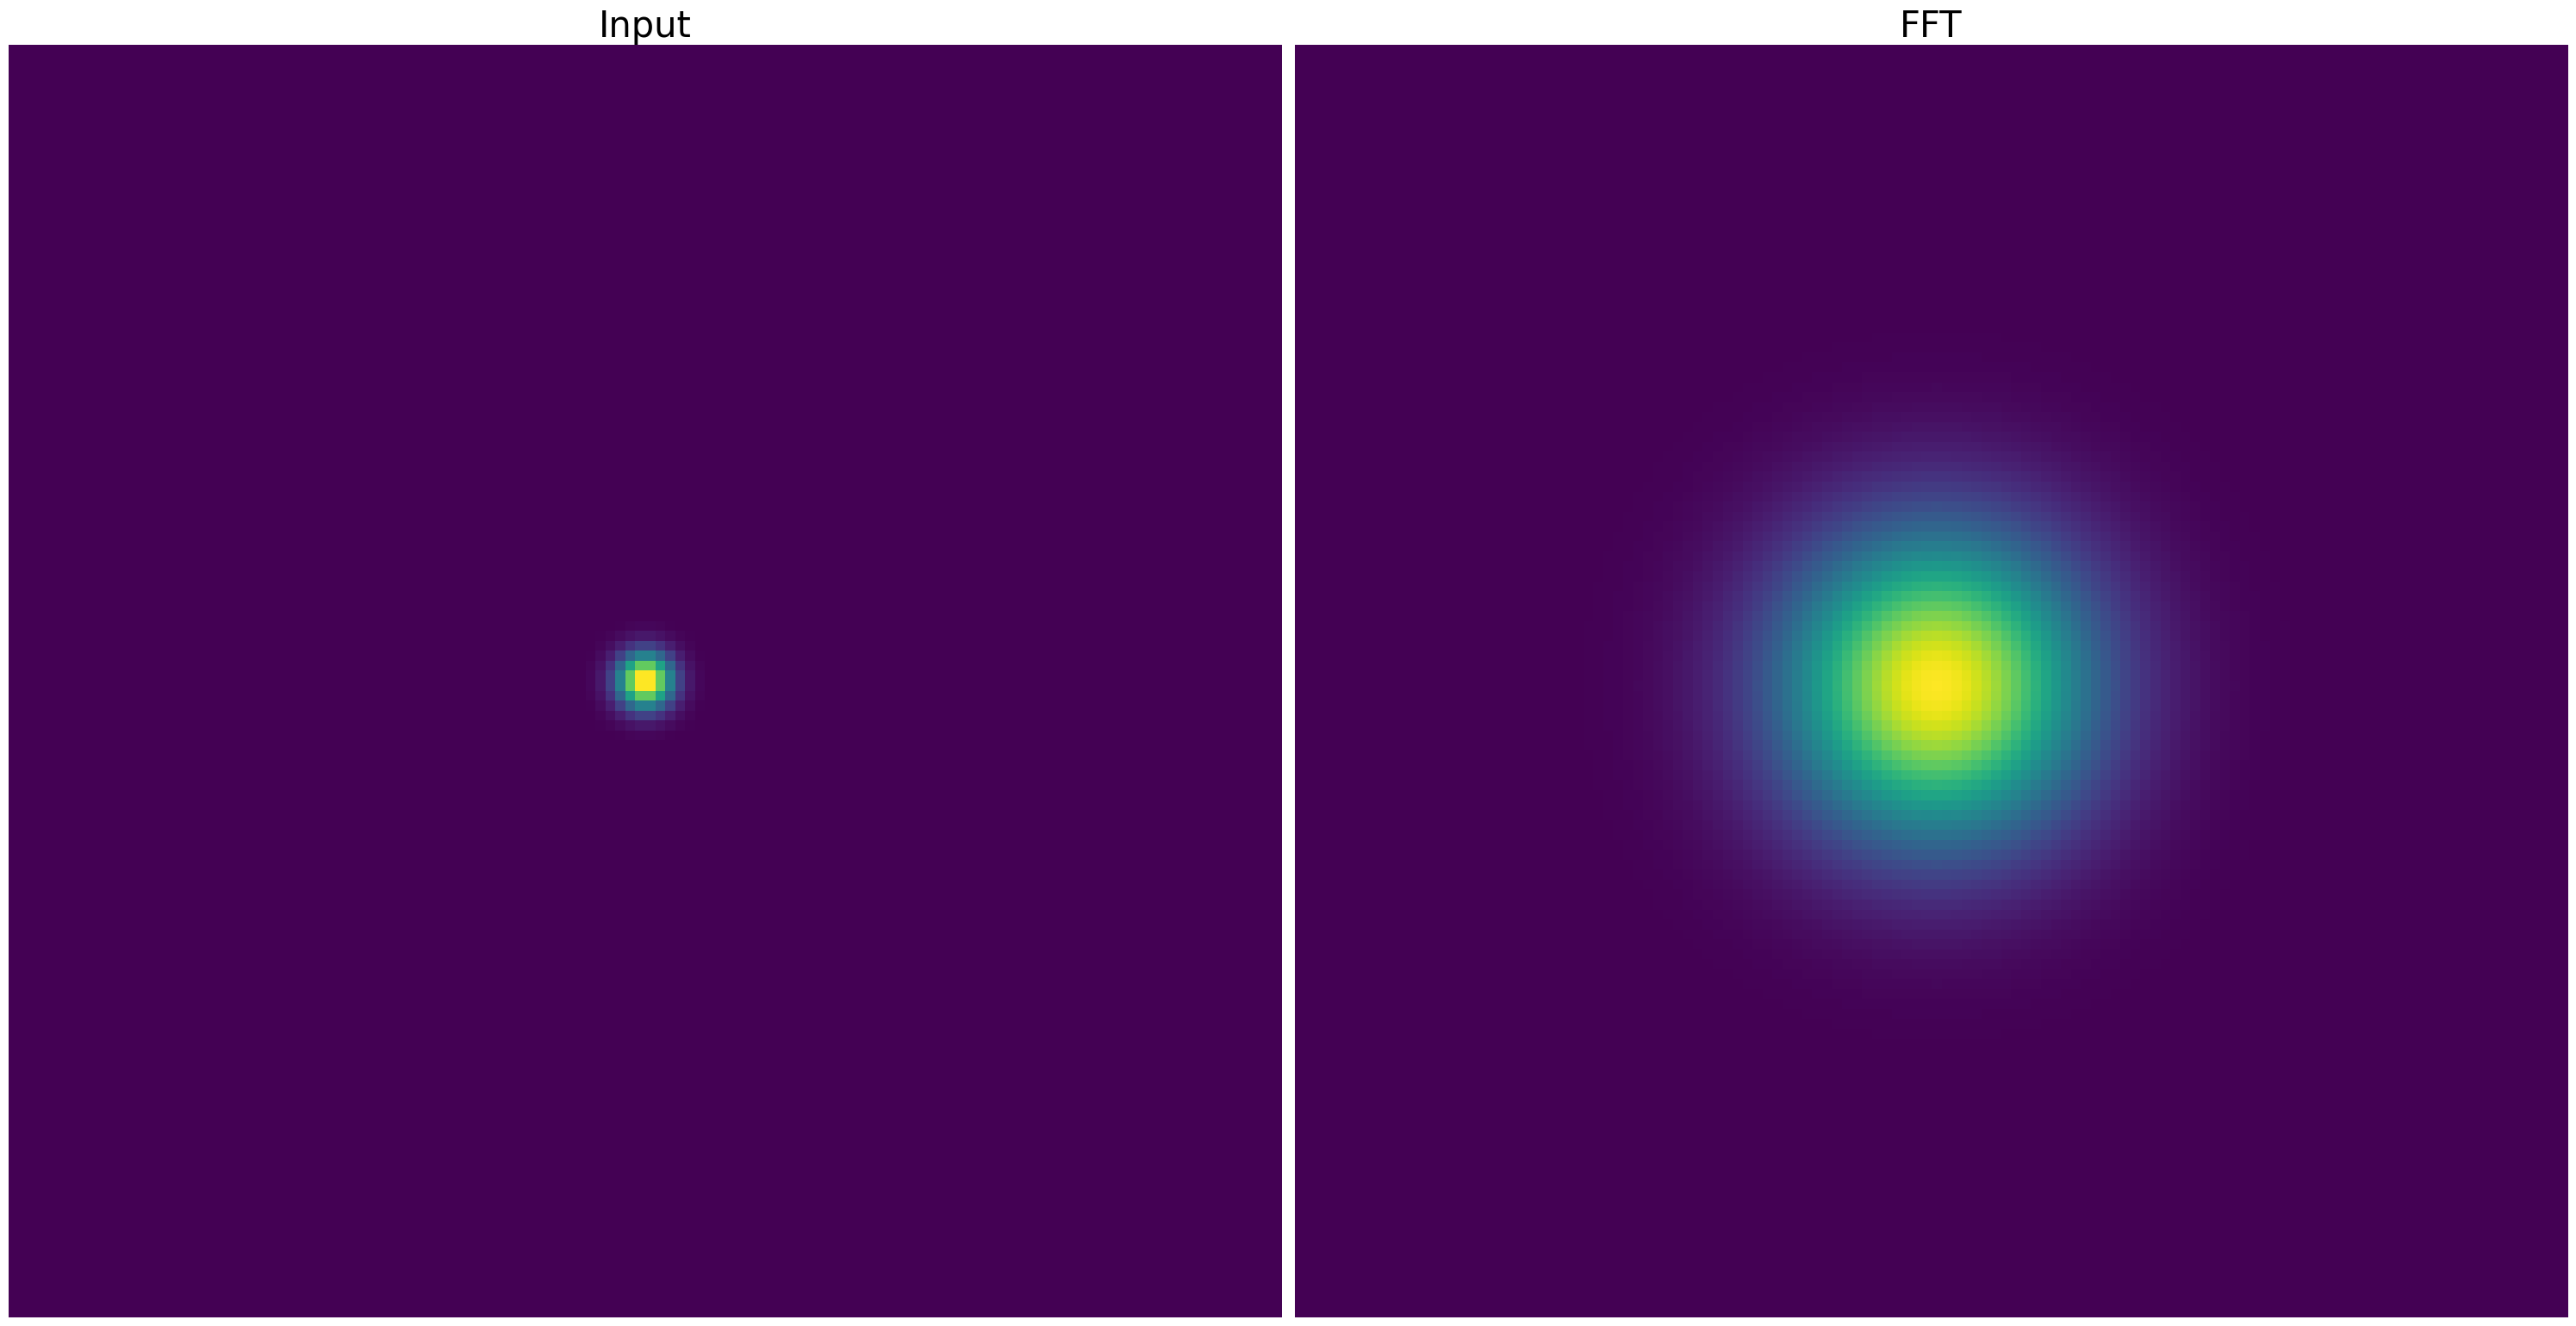

In [3]:
gauss, DFT = FT_by_hand(sigma_x=0.3, sigma_y=0.3)
IDFT = FT_by_hand(img=DFT, FFT=False)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Input large round Gaussian $\rightarrow$ Output: small round Gaussian**

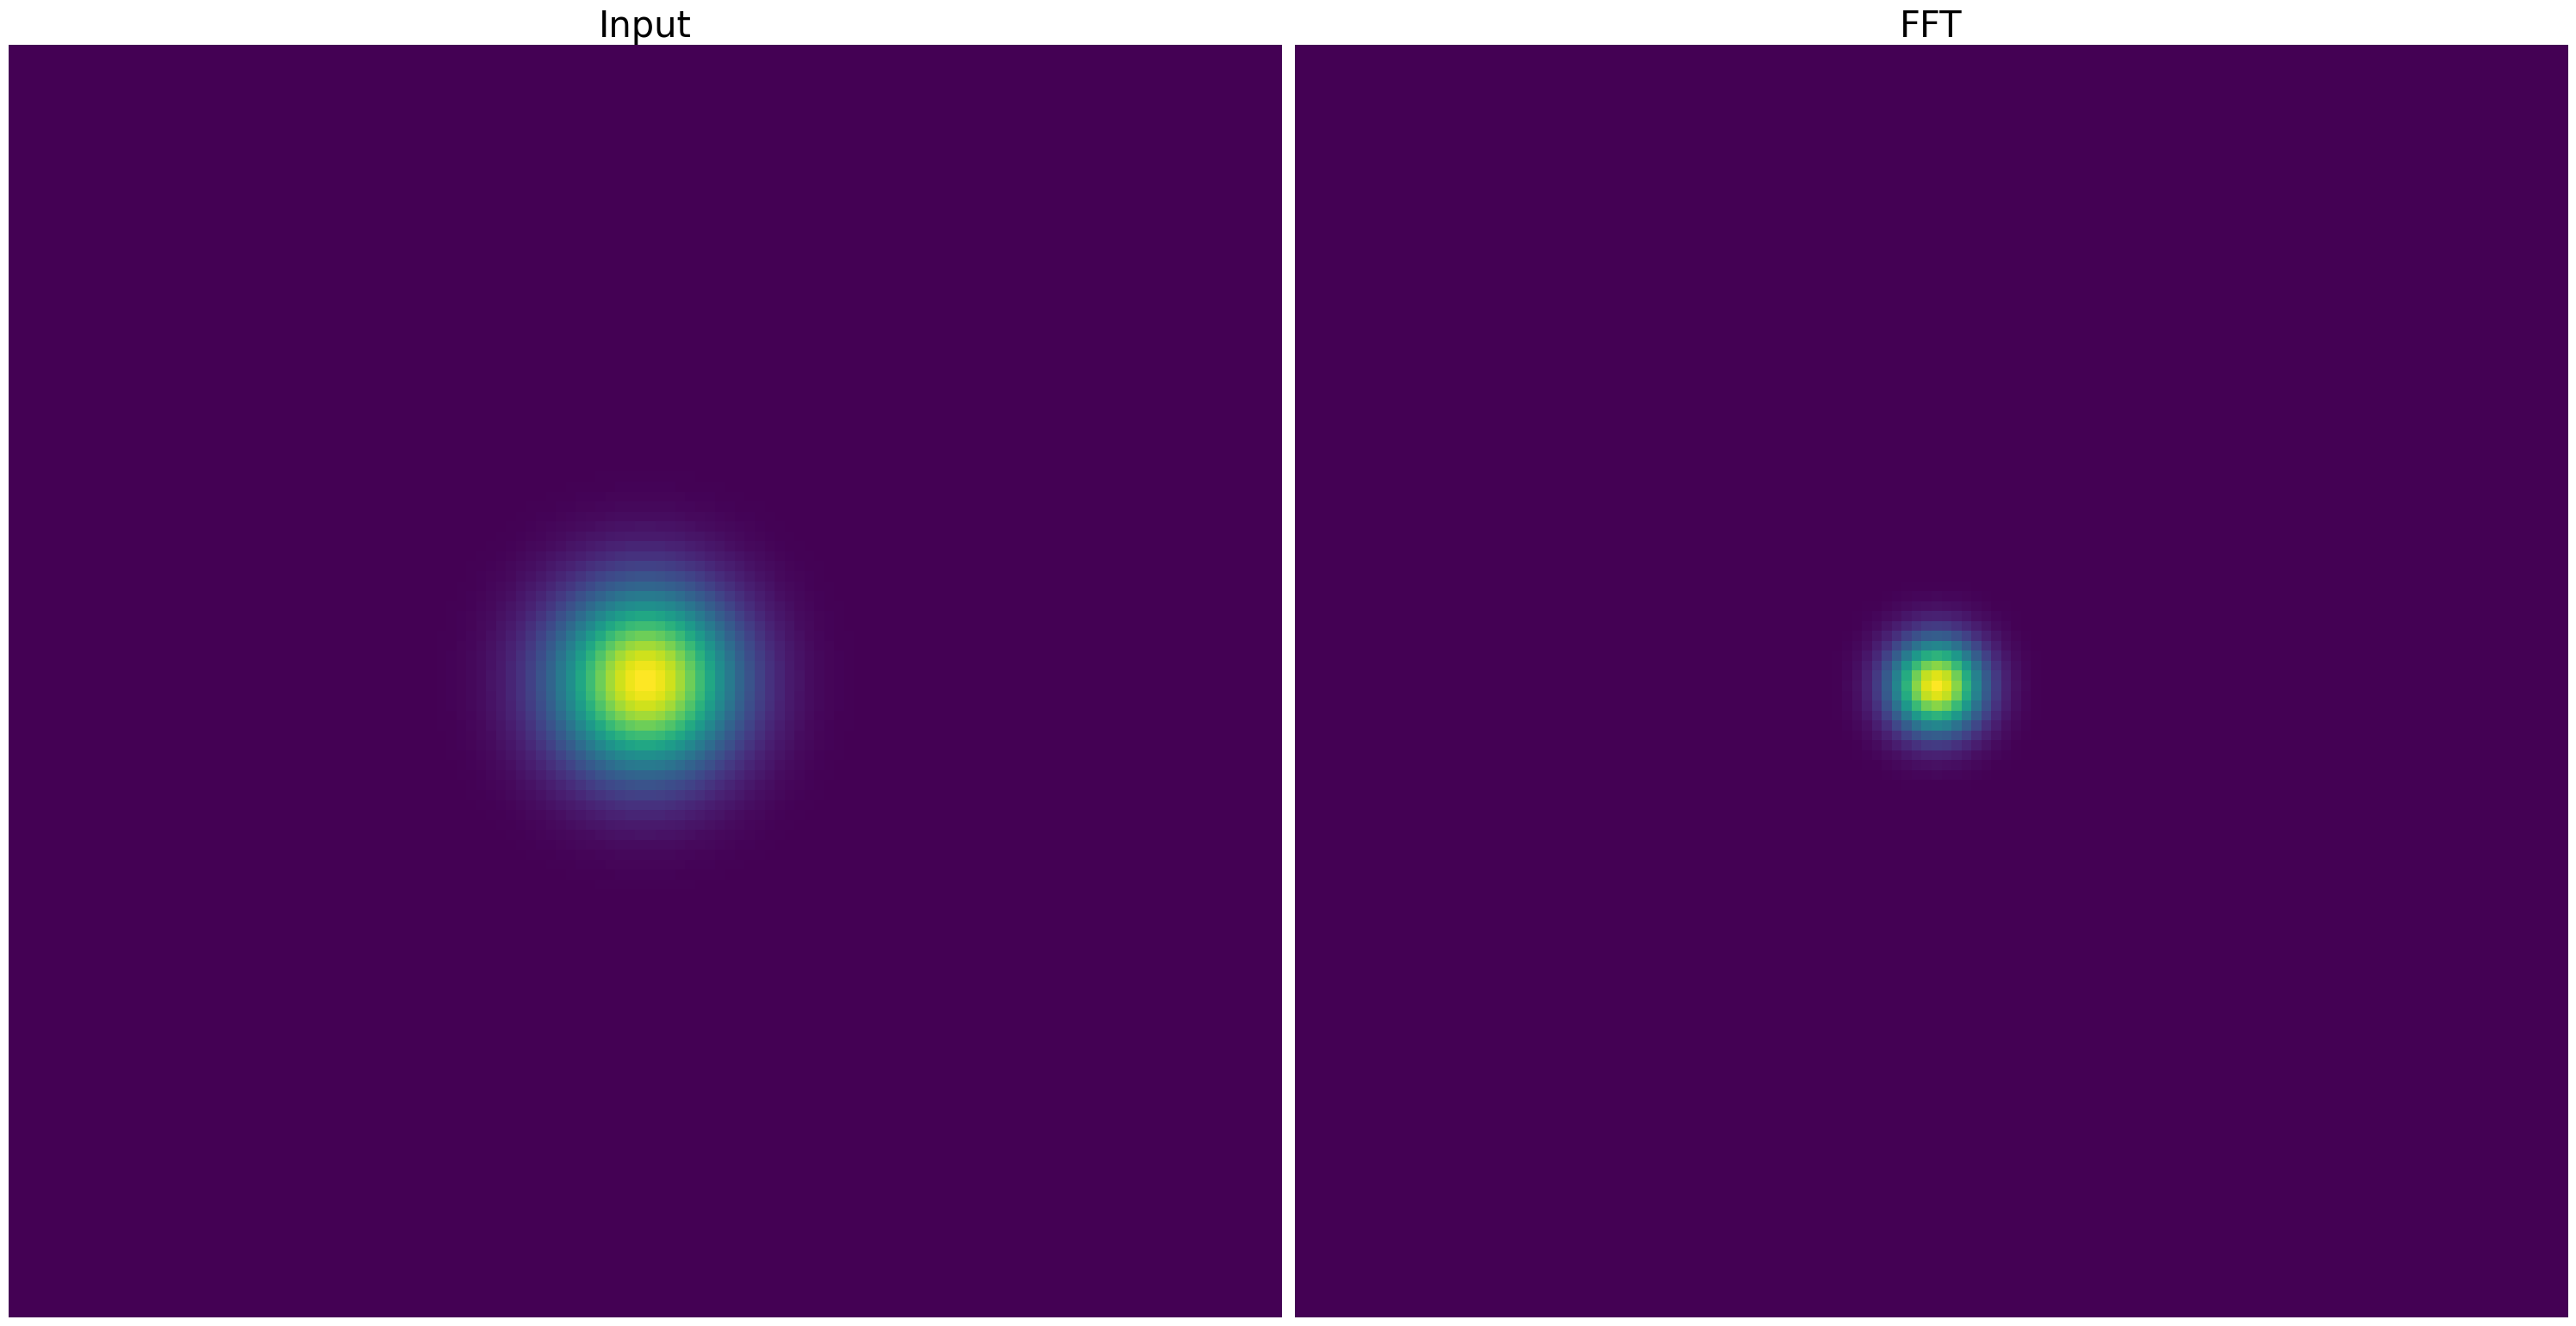

In [4]:
gauss, DFT = FT_by_hand(sigma_x=1.0, sigma_y=1.0)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Small elliptical Gaussian $\rightarrow$ large elliptical Gaussian**

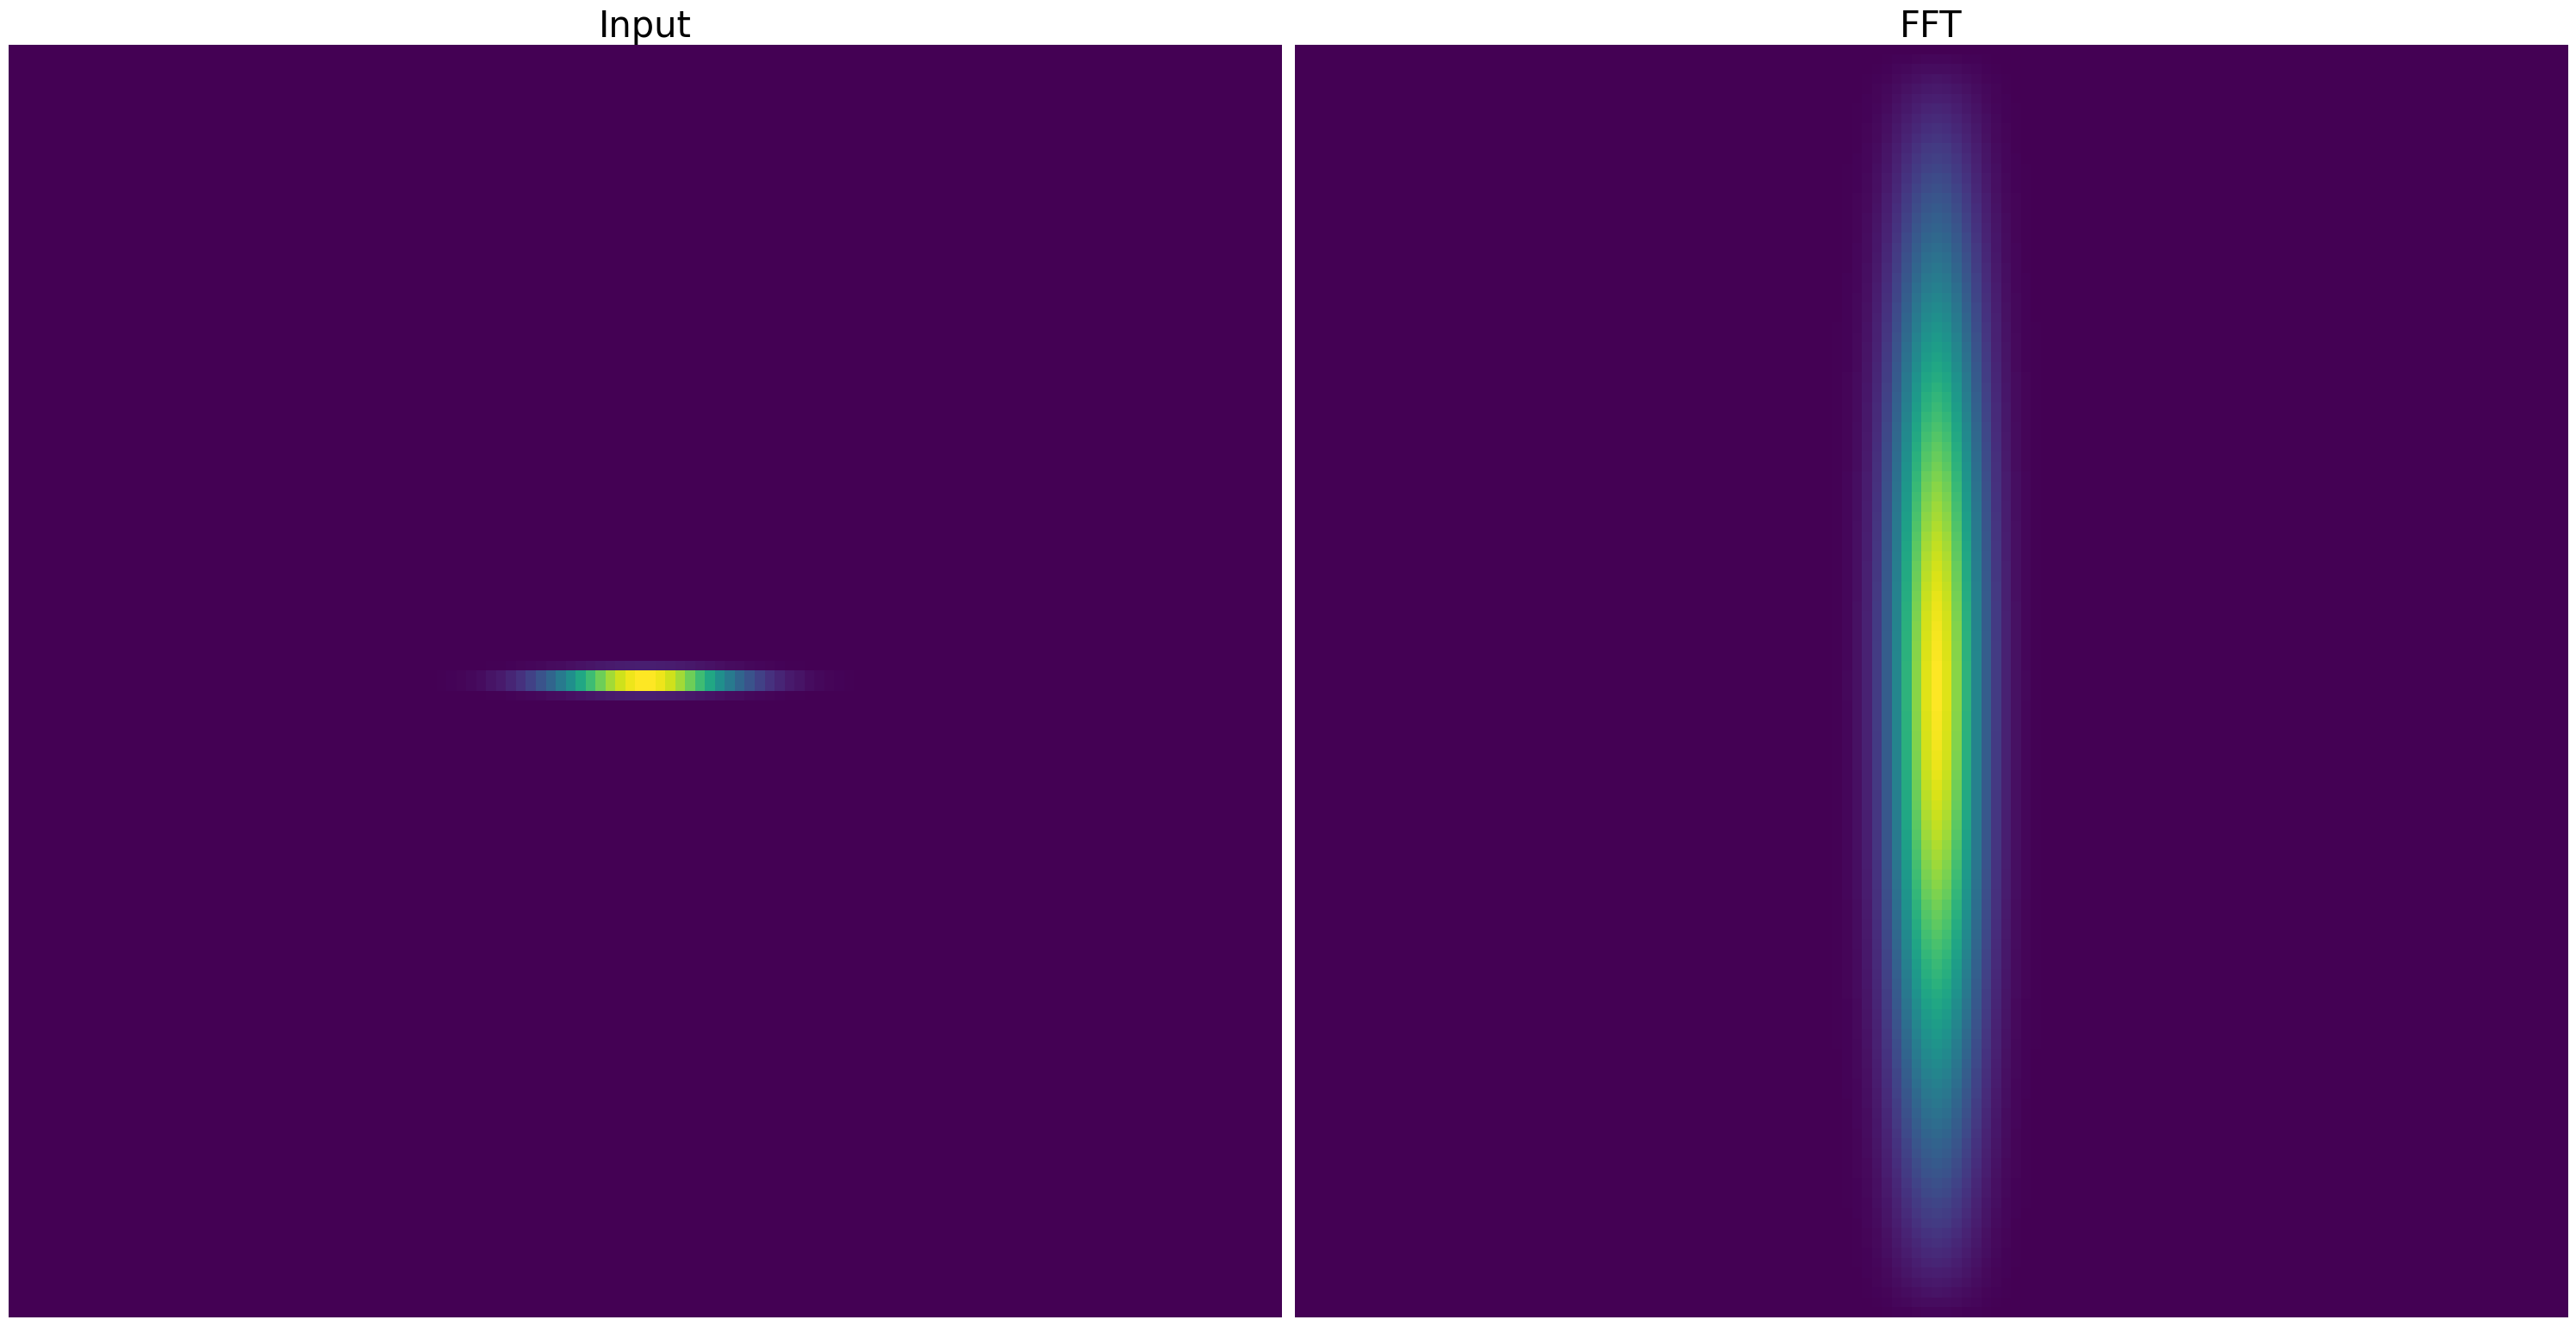

In [5]:
gauss, DFT = FT_by_hand(sigma_x=1, sigma_y=0.1)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Large elliptical $\rightarrow$ FT into small elliptical**

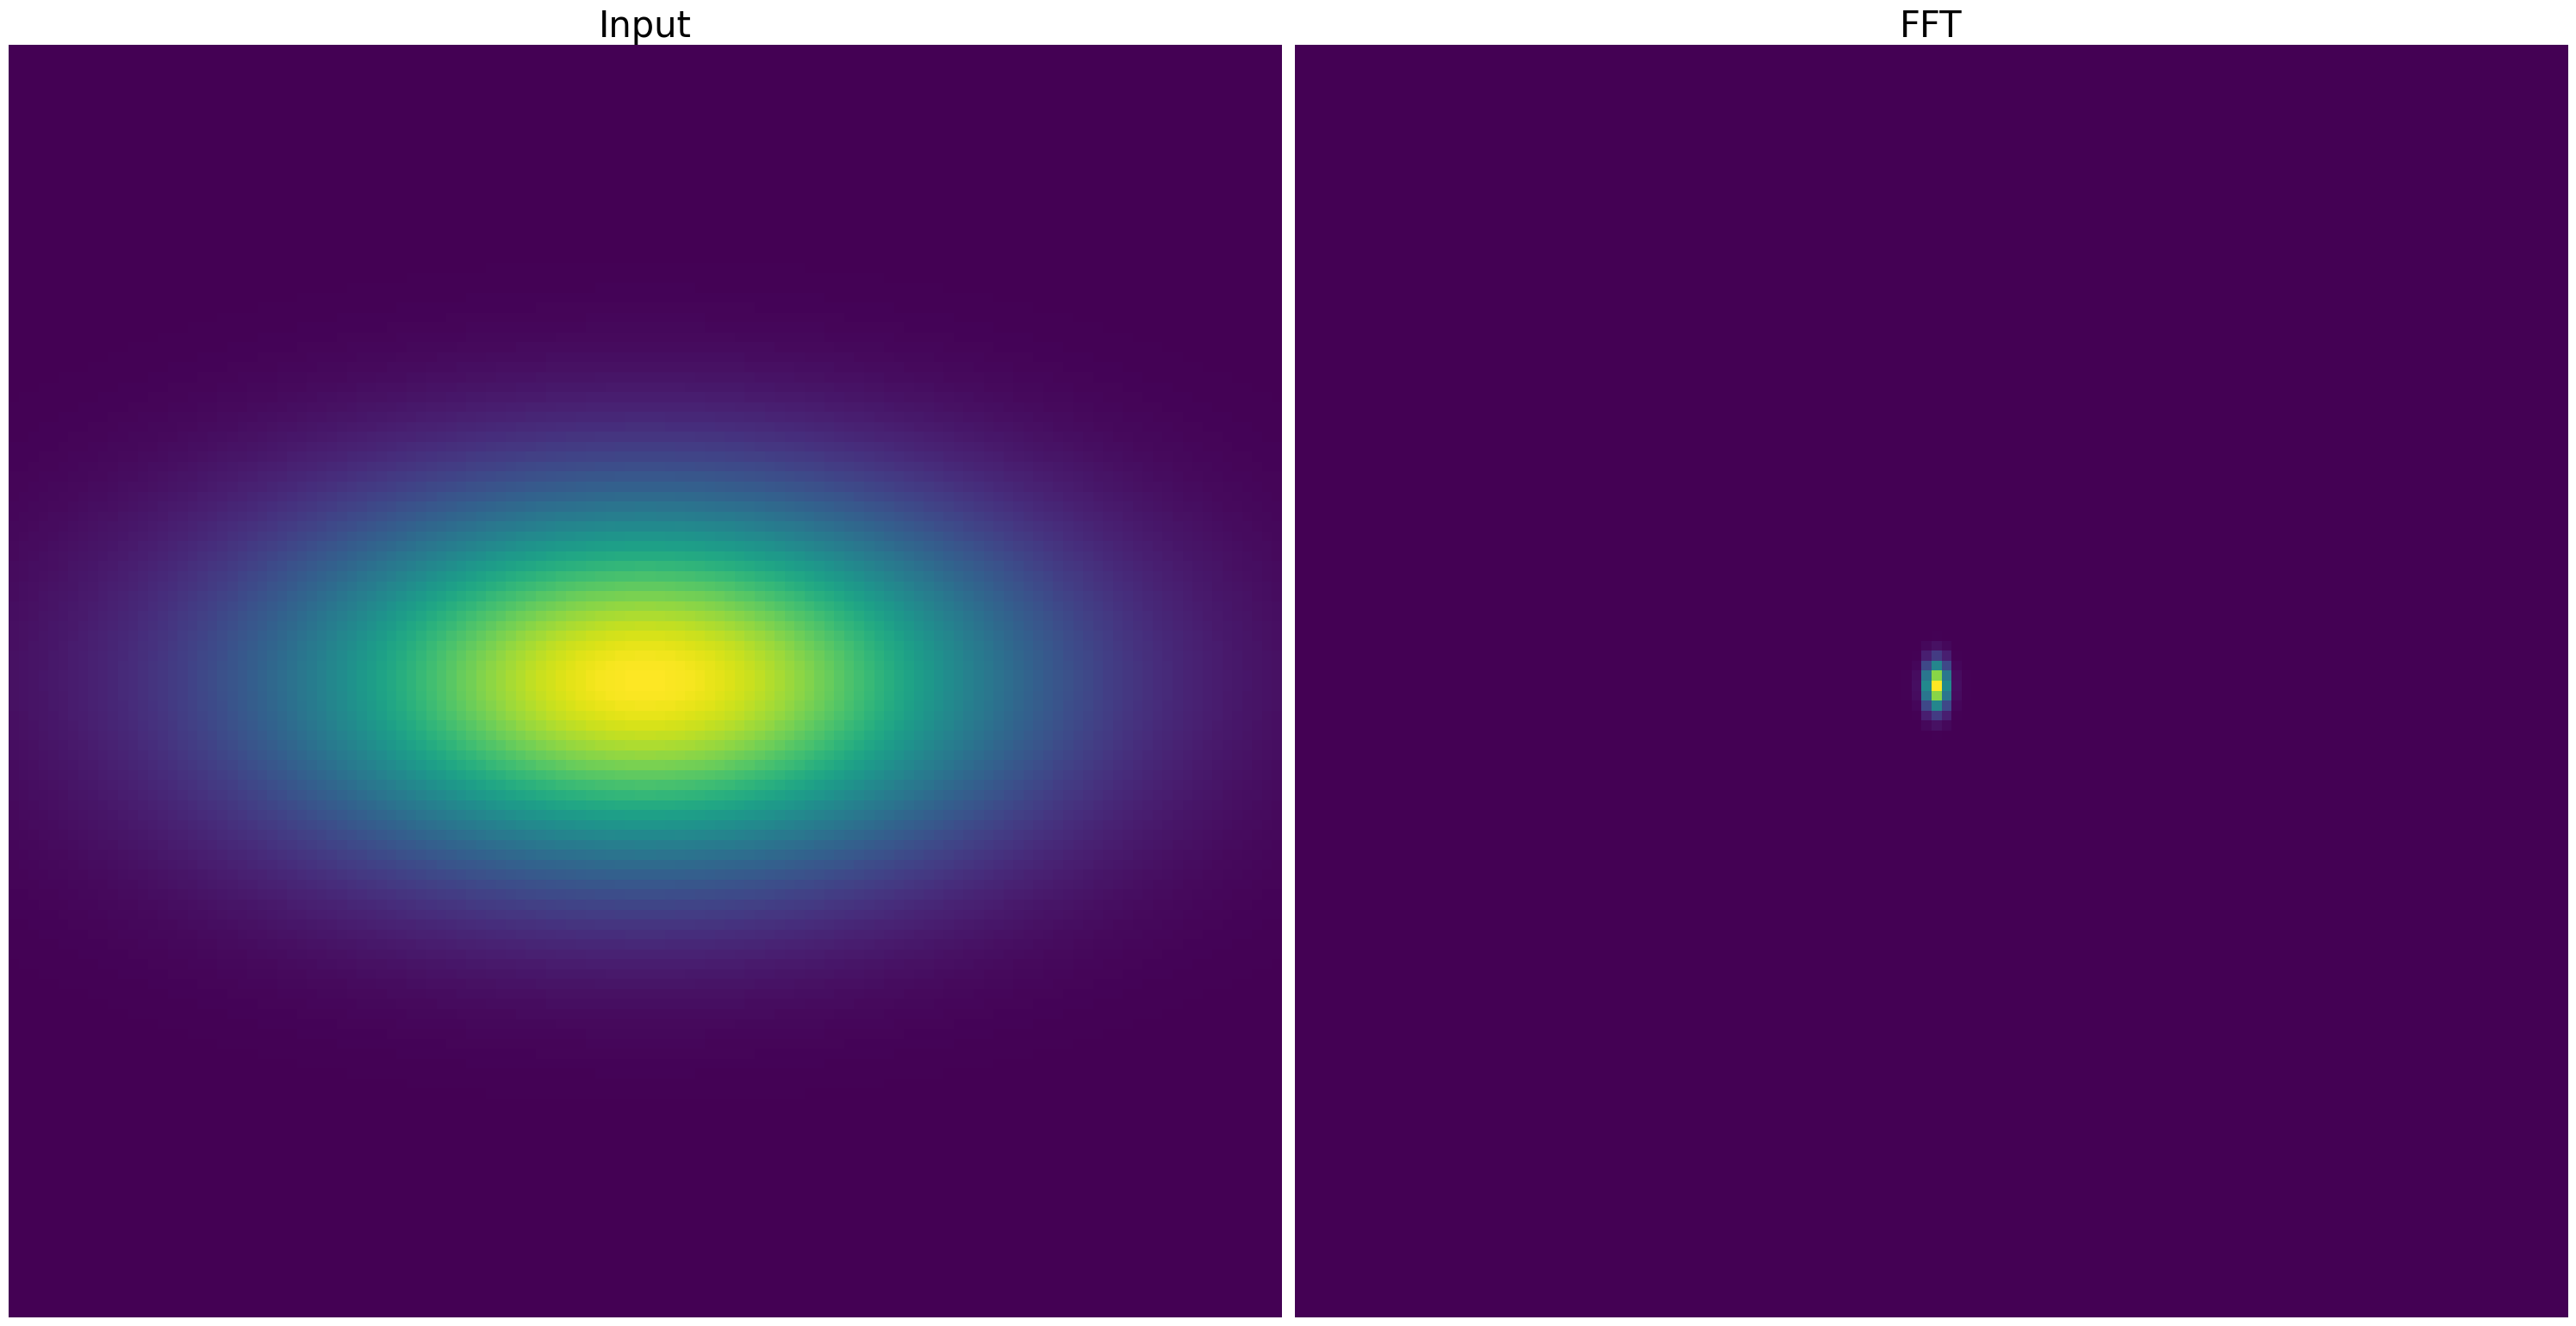

In [6]:
gauss, DFT = FT_by_hand(sigma_x=4, sigma_y=2)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

## 1.2 Rotated Round/Elliptical Gaussians

In [7]:
def gauss2D_rot(x0=0,
                y0=0,
                sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                A=1,
                N=128):
    '''Calculate the values of an unrotated/unstretched Gauss function given positions
    in x and y in a mesh grid.
    
    Args:
    -----
        x: np.ndarray
            Matrix of the x-coordinates that make up the x-coordinates of each point in 
            the meshgrid. 
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        y: np.ndarray
            Matrix of the y-coordinates that make up the y-coordinates of each point in 
            the meshgrid.
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        rho: float
            The correlation coefficient. Measure of direction and magnitude of stretch/
            rotation. Values must be between [-1,1].
            Defaults to 0.5.
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
            
            
    Returns:
    --------
        gauss: np.ndarray
            The array containing the gaussian function evaluated at each point
            in the meshgrid. I.e. returns the image of the Gaussian.
    '''
    x = np.linspace(-10,10,N)
    y = np.linspace(-10,10,N)
    Xg, Yg = np.meshgrid(x, y)


    exp_x = -(Xg-x0)**2 /(2*sigma_x**2 * (1-rho**2))
    exp_y = -(Yg-y0)**2 / (2*sigma_y**2 * (1-rho**2))
    exp_xy = (Xg-x0)*(Yg-y0)*rho / (sigma_x*sigma_y * (1-rho**2))
    
    rot_gauss = A * np.exp(exp_x + exp_y + exp_xy)

    return rot_gauss

def FT_by_hand(img=None,
               x0=0,
               y0=0,
               sigma_x=1.0,
               sigma_y=1.0,
               rho=0.5,
               A=1,
               N=128,
               FFT=True):
    """
    Function that computes the FT via the DFT matrix. This is not optimal,
    one should use the FFT algorithm to compute the DFT, but for learning purposes
    we use this to better understand the FT.
    
    Args:
    -----
    
    Returns:
    -------
    """
    # Create Gaussian
    gauss = gauss2D_rot(x0=x0,
                    y0=y0,
                    sigma_x=sigma_x,
                    sigma_y=sigma_y,
                    rho=rho,
                    A=A)

    #DFT matrix calc
    n=128
    w = np.exp(-1j * 2 * np.pi / n)
    J, K = np.meshgrid(np.arange(n), np.arange(n))
    DFT_mat = np.power(w, J*K)
    
    if FFT==True:
        # Create empty arrays for use in DFT calc
        DFT_y = np.zeros((n,n), dtype=np.complex128)
        DFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            DFT_y[i,:] += np.dot(DFT_mat, gauss[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            DFT[:,j] += np.dot(DFT_mat, DFT_y[:,j])

        # Center the lowest frequencies in the center of the image
        DFT = np.fft.fftshift(DFT)
        
        return gauss, DFT
        
    else:
        
        w = np.exp(1j * 2 * np.pi / n)
        J, K = np.meshgrid(np.arange(n), np.arange(n))
        IDFT_mat = np.power(w, J*K)
        
        # Create empty arrays for use in DFT calc
        IDFT_y = np.zeros((n,n), dtype=np.complex128)
        IDFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            IDFT_y[i,:] += np.dot(IDFT_mat, img[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            IDFT[:,j] += np.dot(IDFT_mat, IDFT_y[:,j])

        # Center the lowest frequencies in the center of the image
#         IDFT = np.fft.fftshift(IDFT)   
        return IDFT

**FT of small round gaussian $\rightarrow$ large FT Gaussian**

In [8]:
def analytical_rotgauss_FT(sigma_x=1.0,
                            sigma_y=1.0,
                            rho=0.5,
                            A=1,
                            N=128):

    u = np.linspace(-10,10,N)
    v = np.linspace(-10,10,N)
    Ug, Vg = np.meshgrid(u, v)
    
    prefactor_num_const = -2*A*np.pi*sigma_x*sigma_y*(1-rho**2)*np.sqrt(1 - rho**2*(1-rho**2))
    prefactor_denom_const = rho**2*(1-rho) - 1
    prefactor_num_expo = np.exp(-2*np.pi*Ug**2*sigma_x**2*(1-rho**2))
    prefactor = (prefactor_num_const/prefactor_denom_const) * prefactor_num_expo
    
    expo_num = 2*np.pi**2 * (Vg + Ug*rho*sigma_x)**2 * sigma_y**2 * (1-rho**2)
    expo_denom = rho**2 * (1-rho**2) -1
    expo = np.exp(expo_num/expo_denom)
    
    gauss_rot_FT = prefactor * expo
    
    return gauss_rot_FT

**Testing to see if my analytical function of the rotated 2d elliptical gaussian FT is the same as what I would get from doing an FFT**

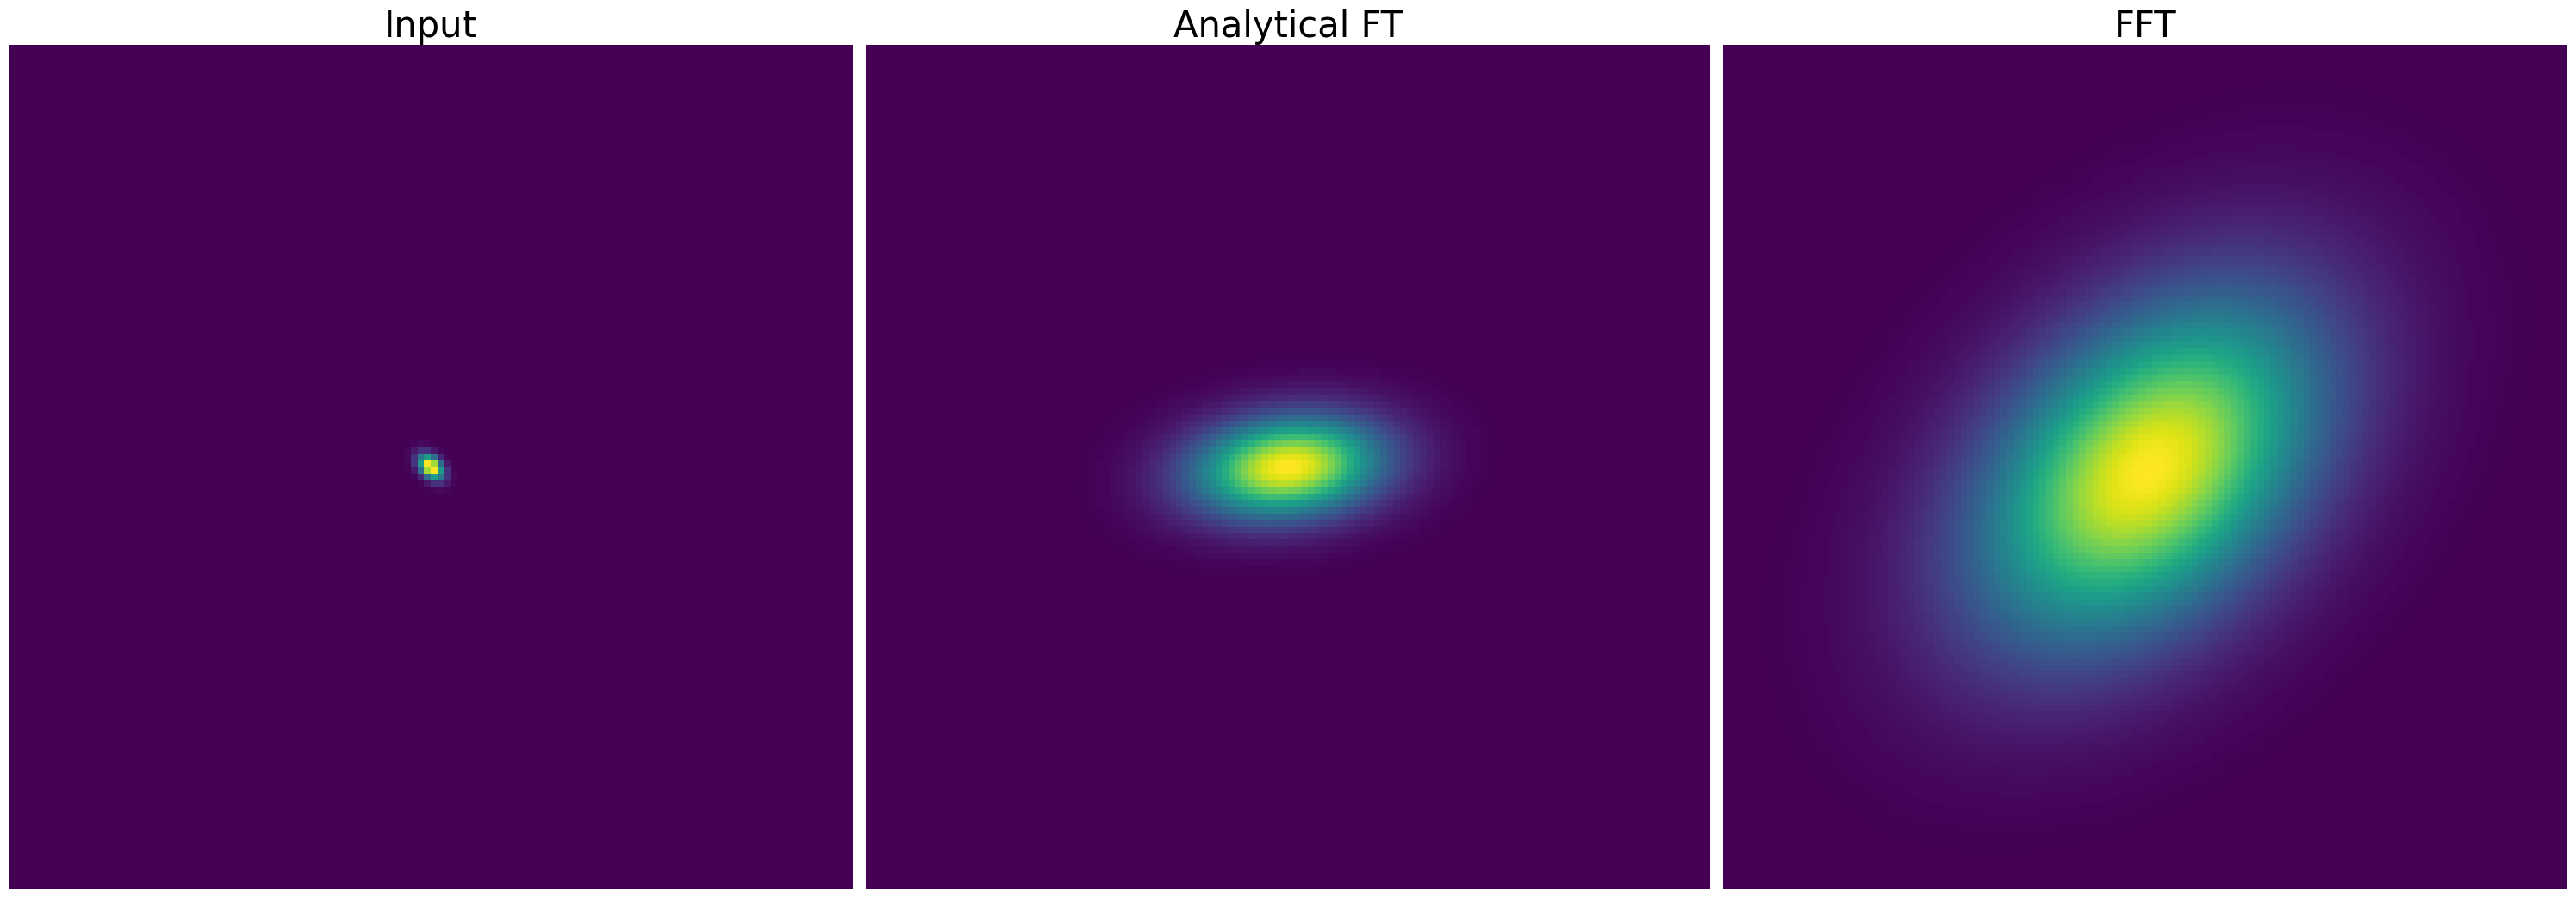

In [28]:
# Analytical FT of rotated Gaussian
aFT_gauss = analytical_rotgauss_FT(sigma_x=0.2,
                                sigma_y=0.2,
                                rho=0.4)

# Rotated gaussian
gauss = gauss2D_rot(sigma_x=0.2,
            sigma_y=0.2,
            rho=0.4)
# FFT of the rotated gaussian
FT_gauss = fft.fftshift(fft.fft2(gauss))

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(aFT_gauss)
axes[1].axis('off')
axes[1].set_title('Analytical FT', fontsize=30)
axes[2].imshow(np.abs(FT_gauss))
axes[2].axis('off')
axes[2].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

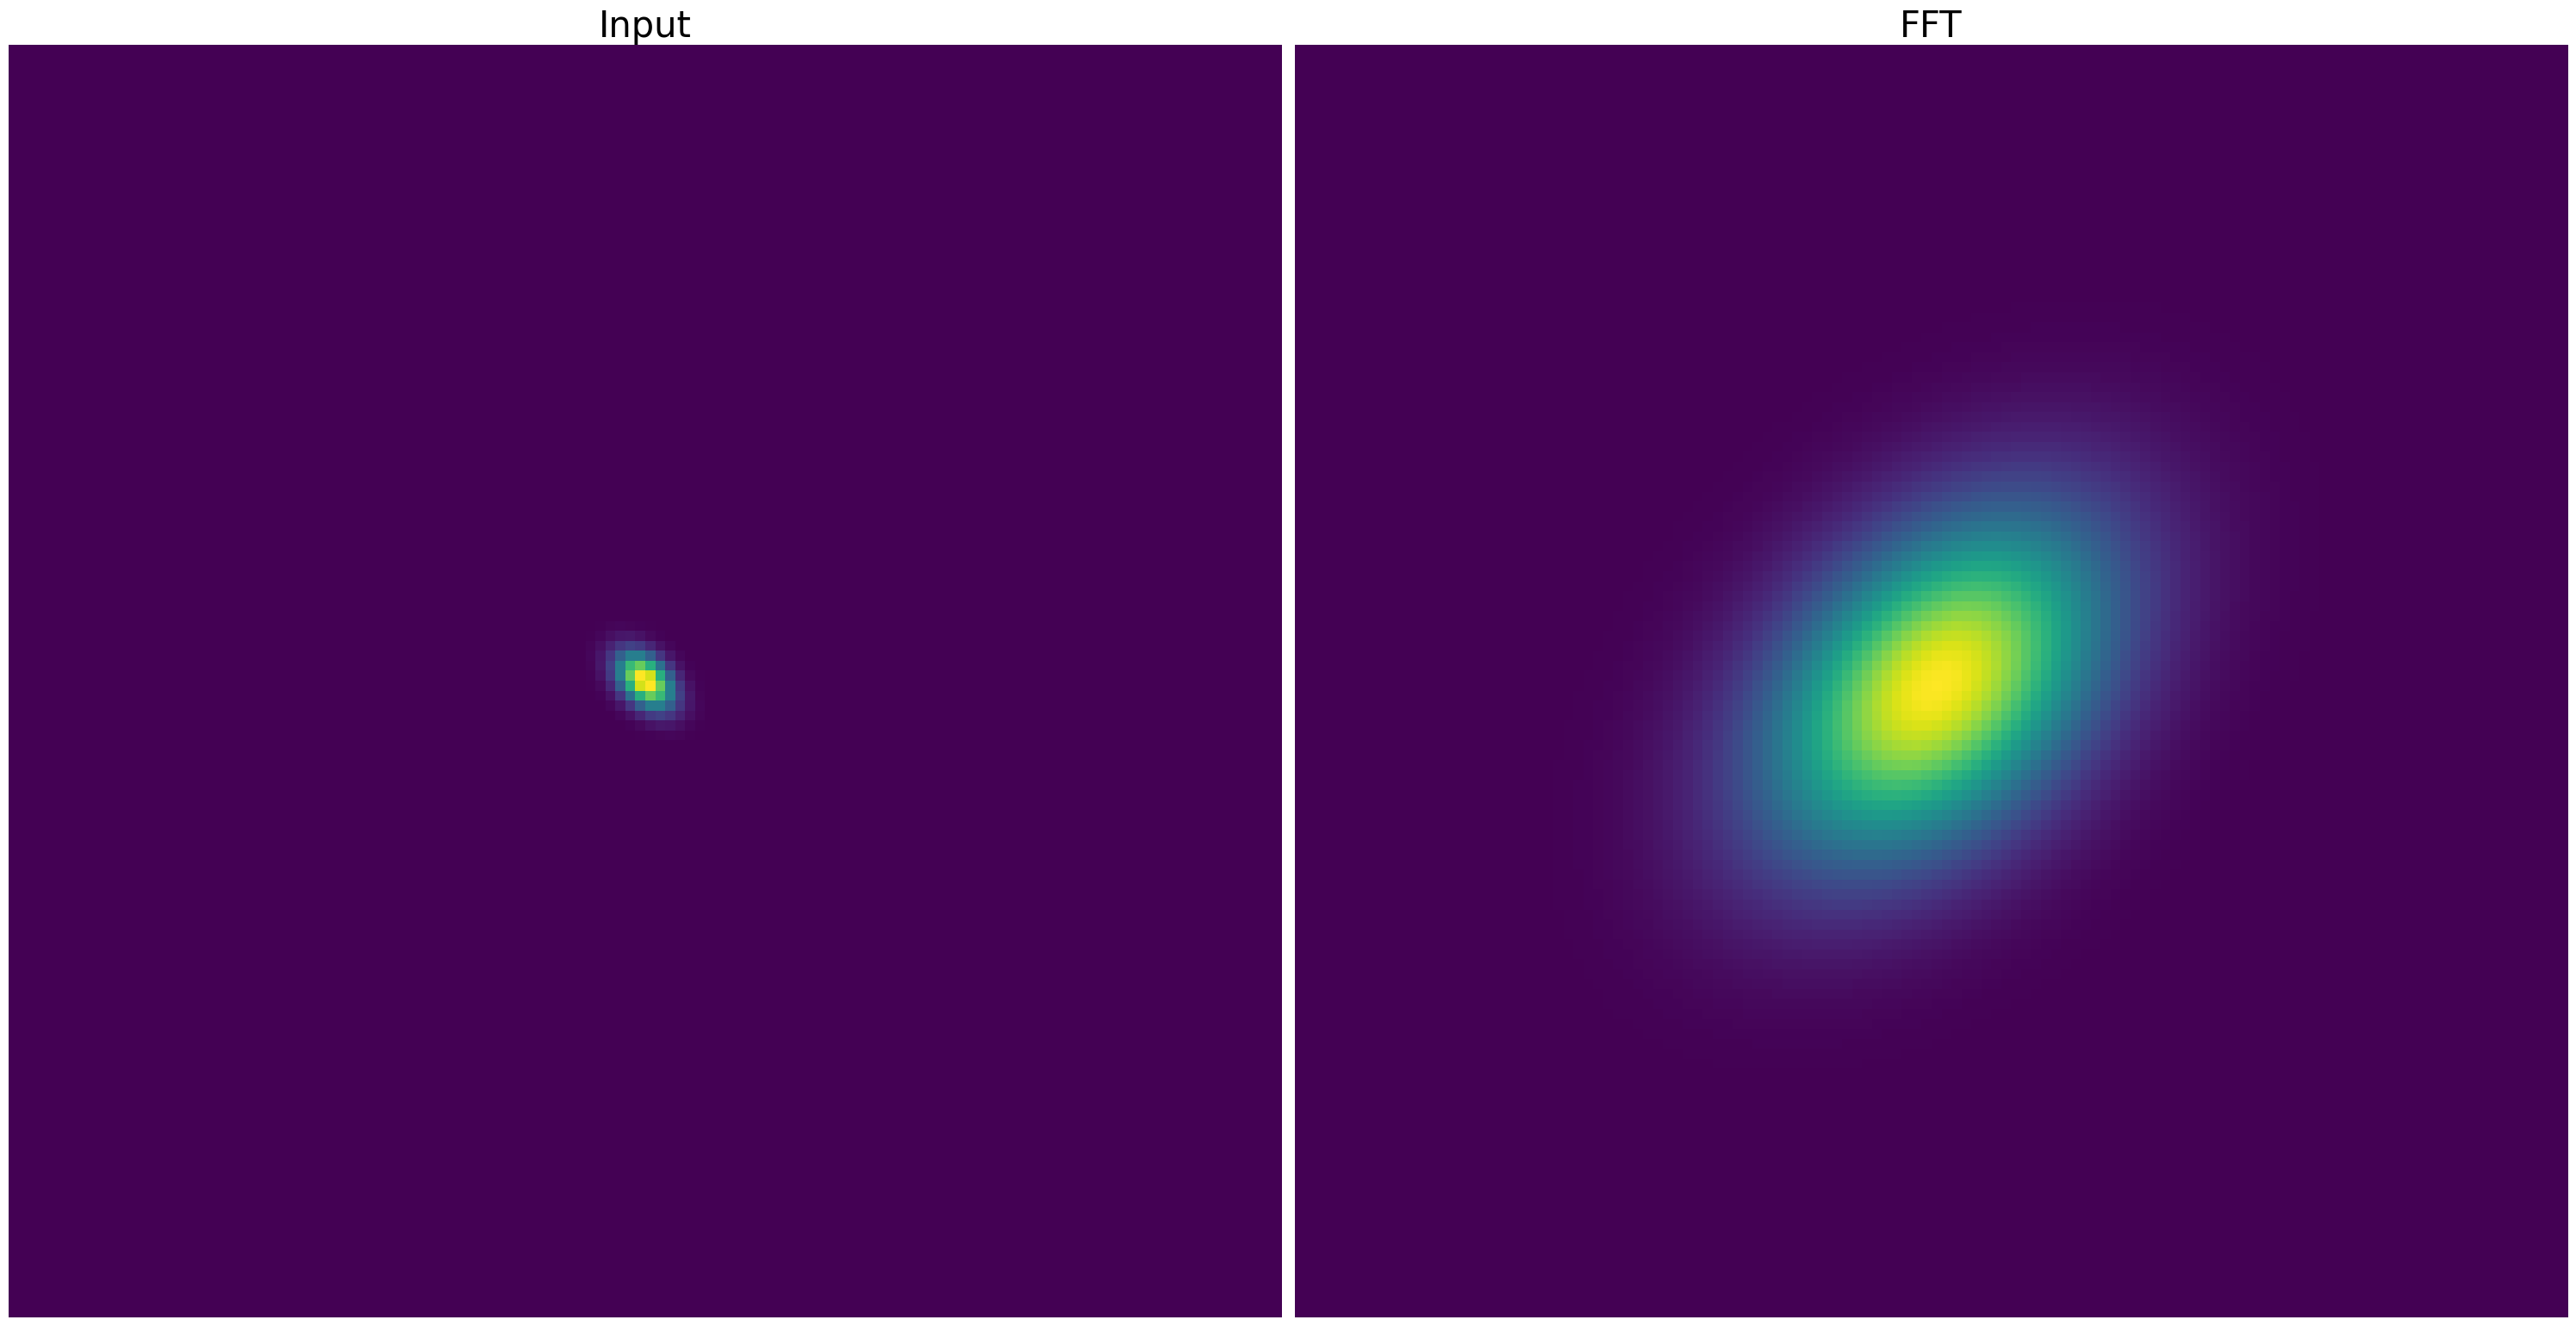

In [10]:
gauss, DFT = FT_by_hand(sigma_x=0.3, sigma_y=0.3, rho=0.4)
IDFT = FT_by_hand(img=DFT, FFT=False)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Input large round Gaussian $\rightarrow$ Output: small round Gaussian**

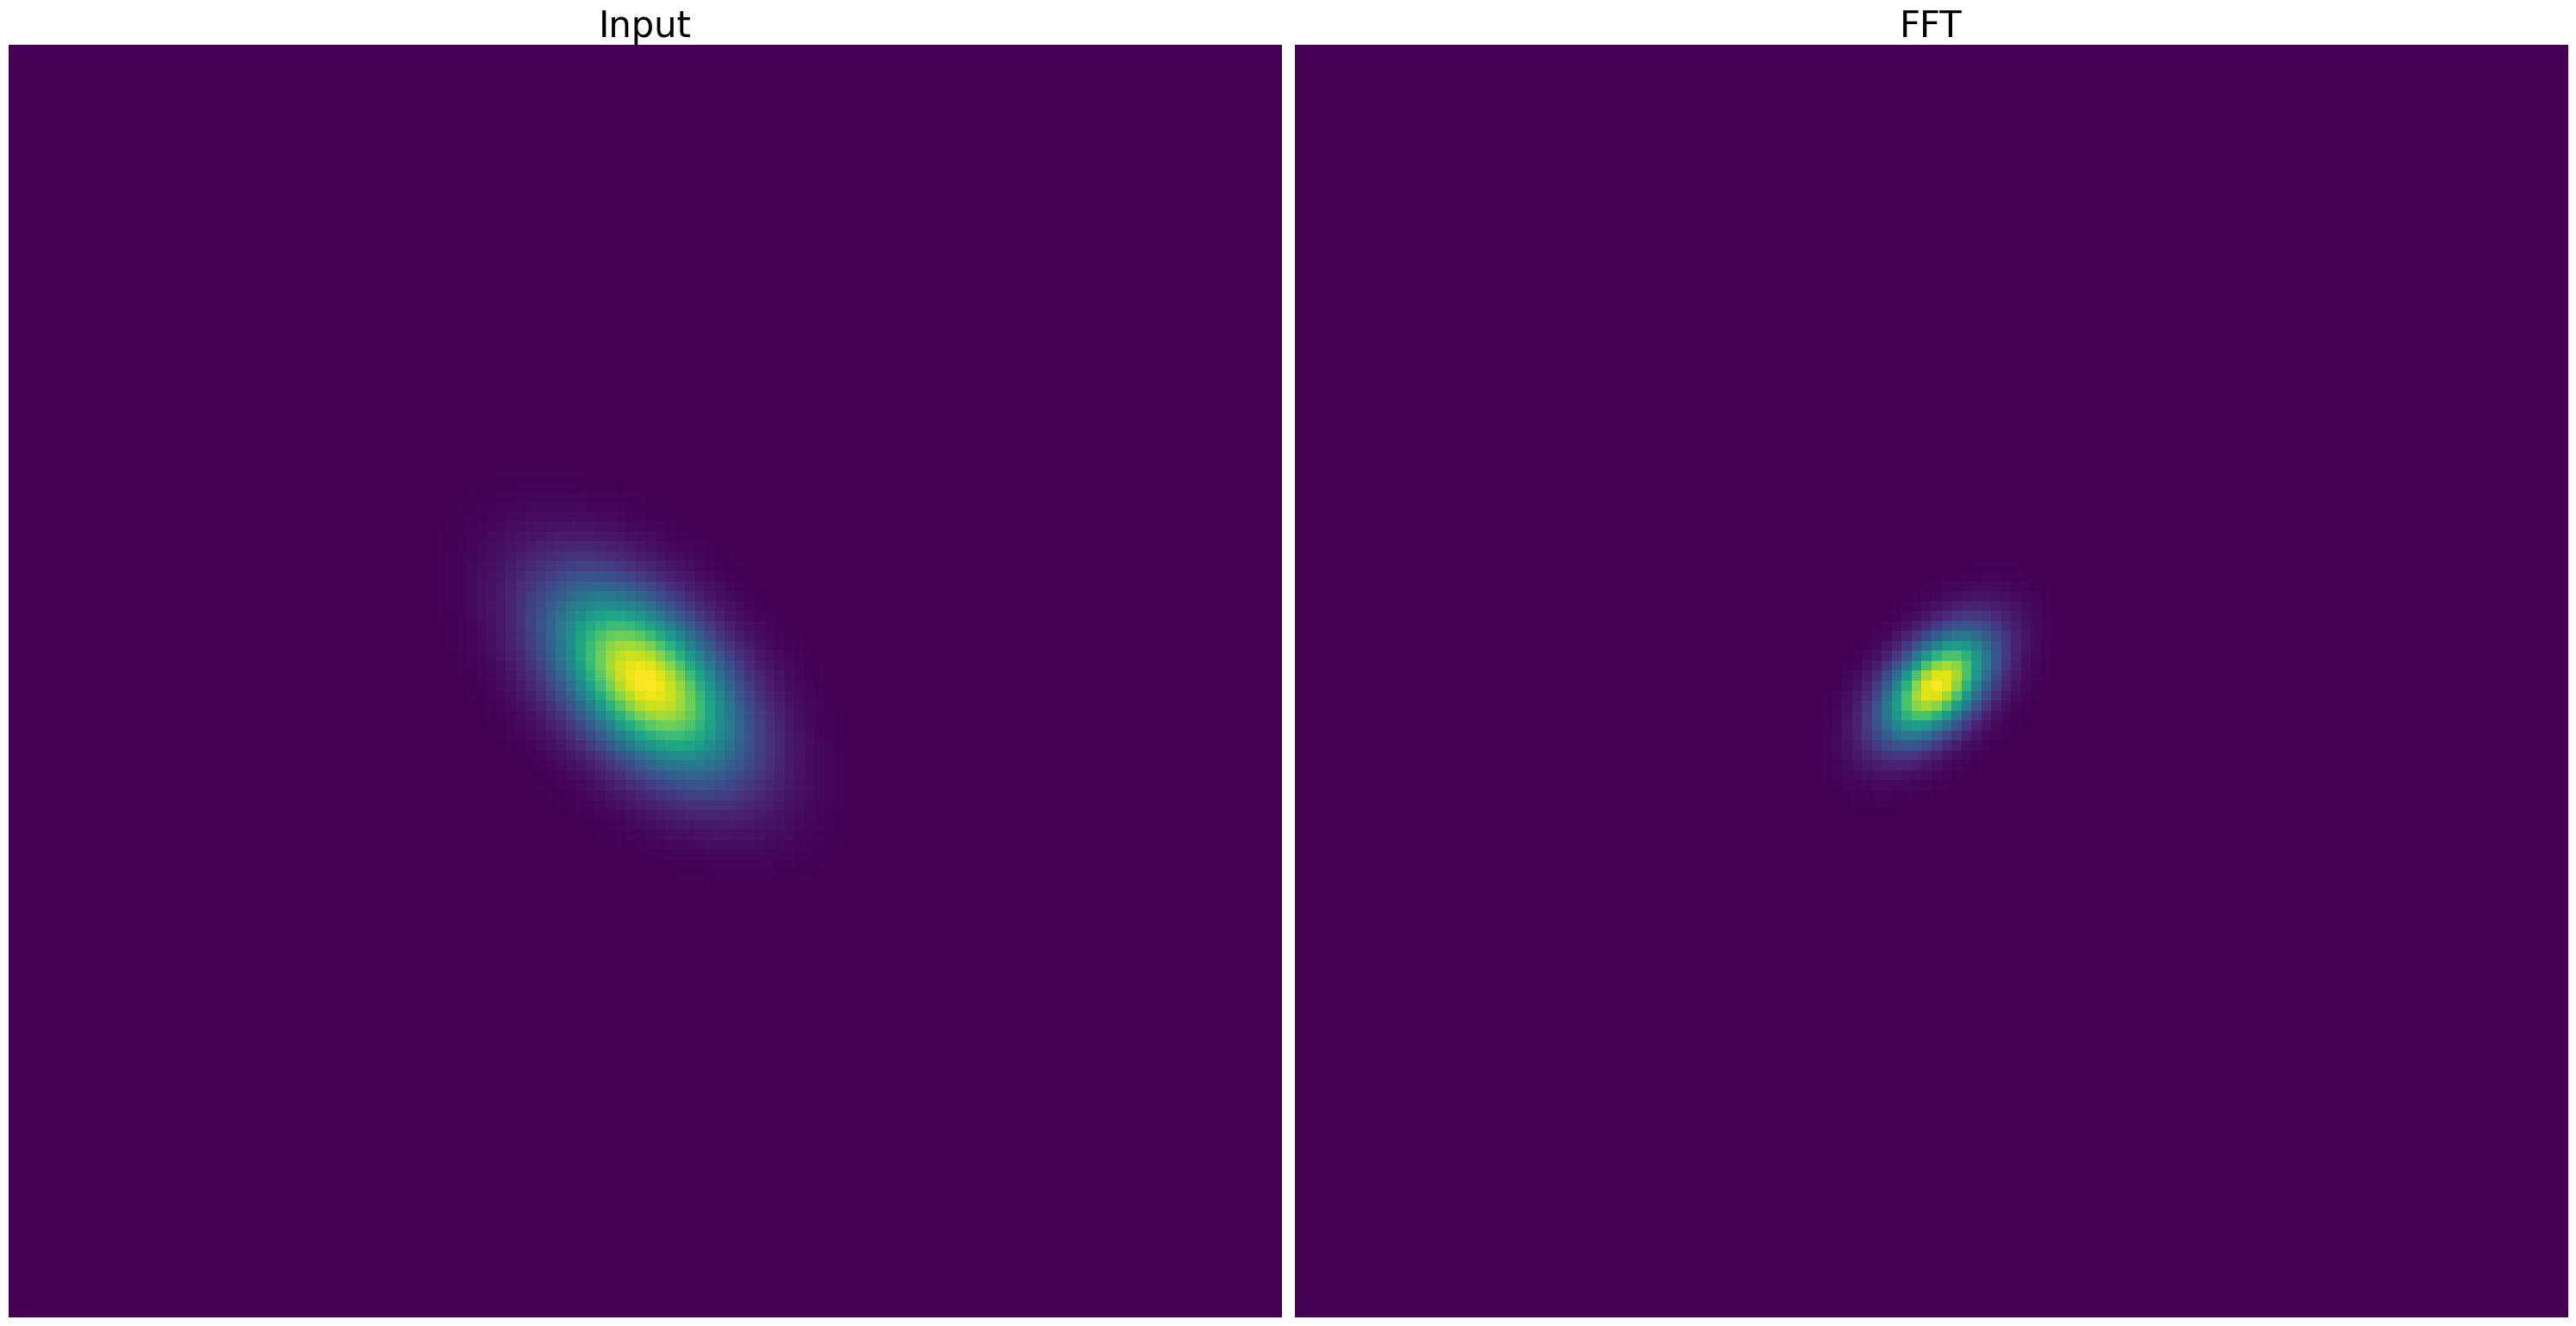

In [11]:
gauss, DFT = FT_by_hand(sigma_x=1.0, sigma_y=1.0)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Small elliptical Gaussian $\rightarrow$ large elliptical Gaussian**

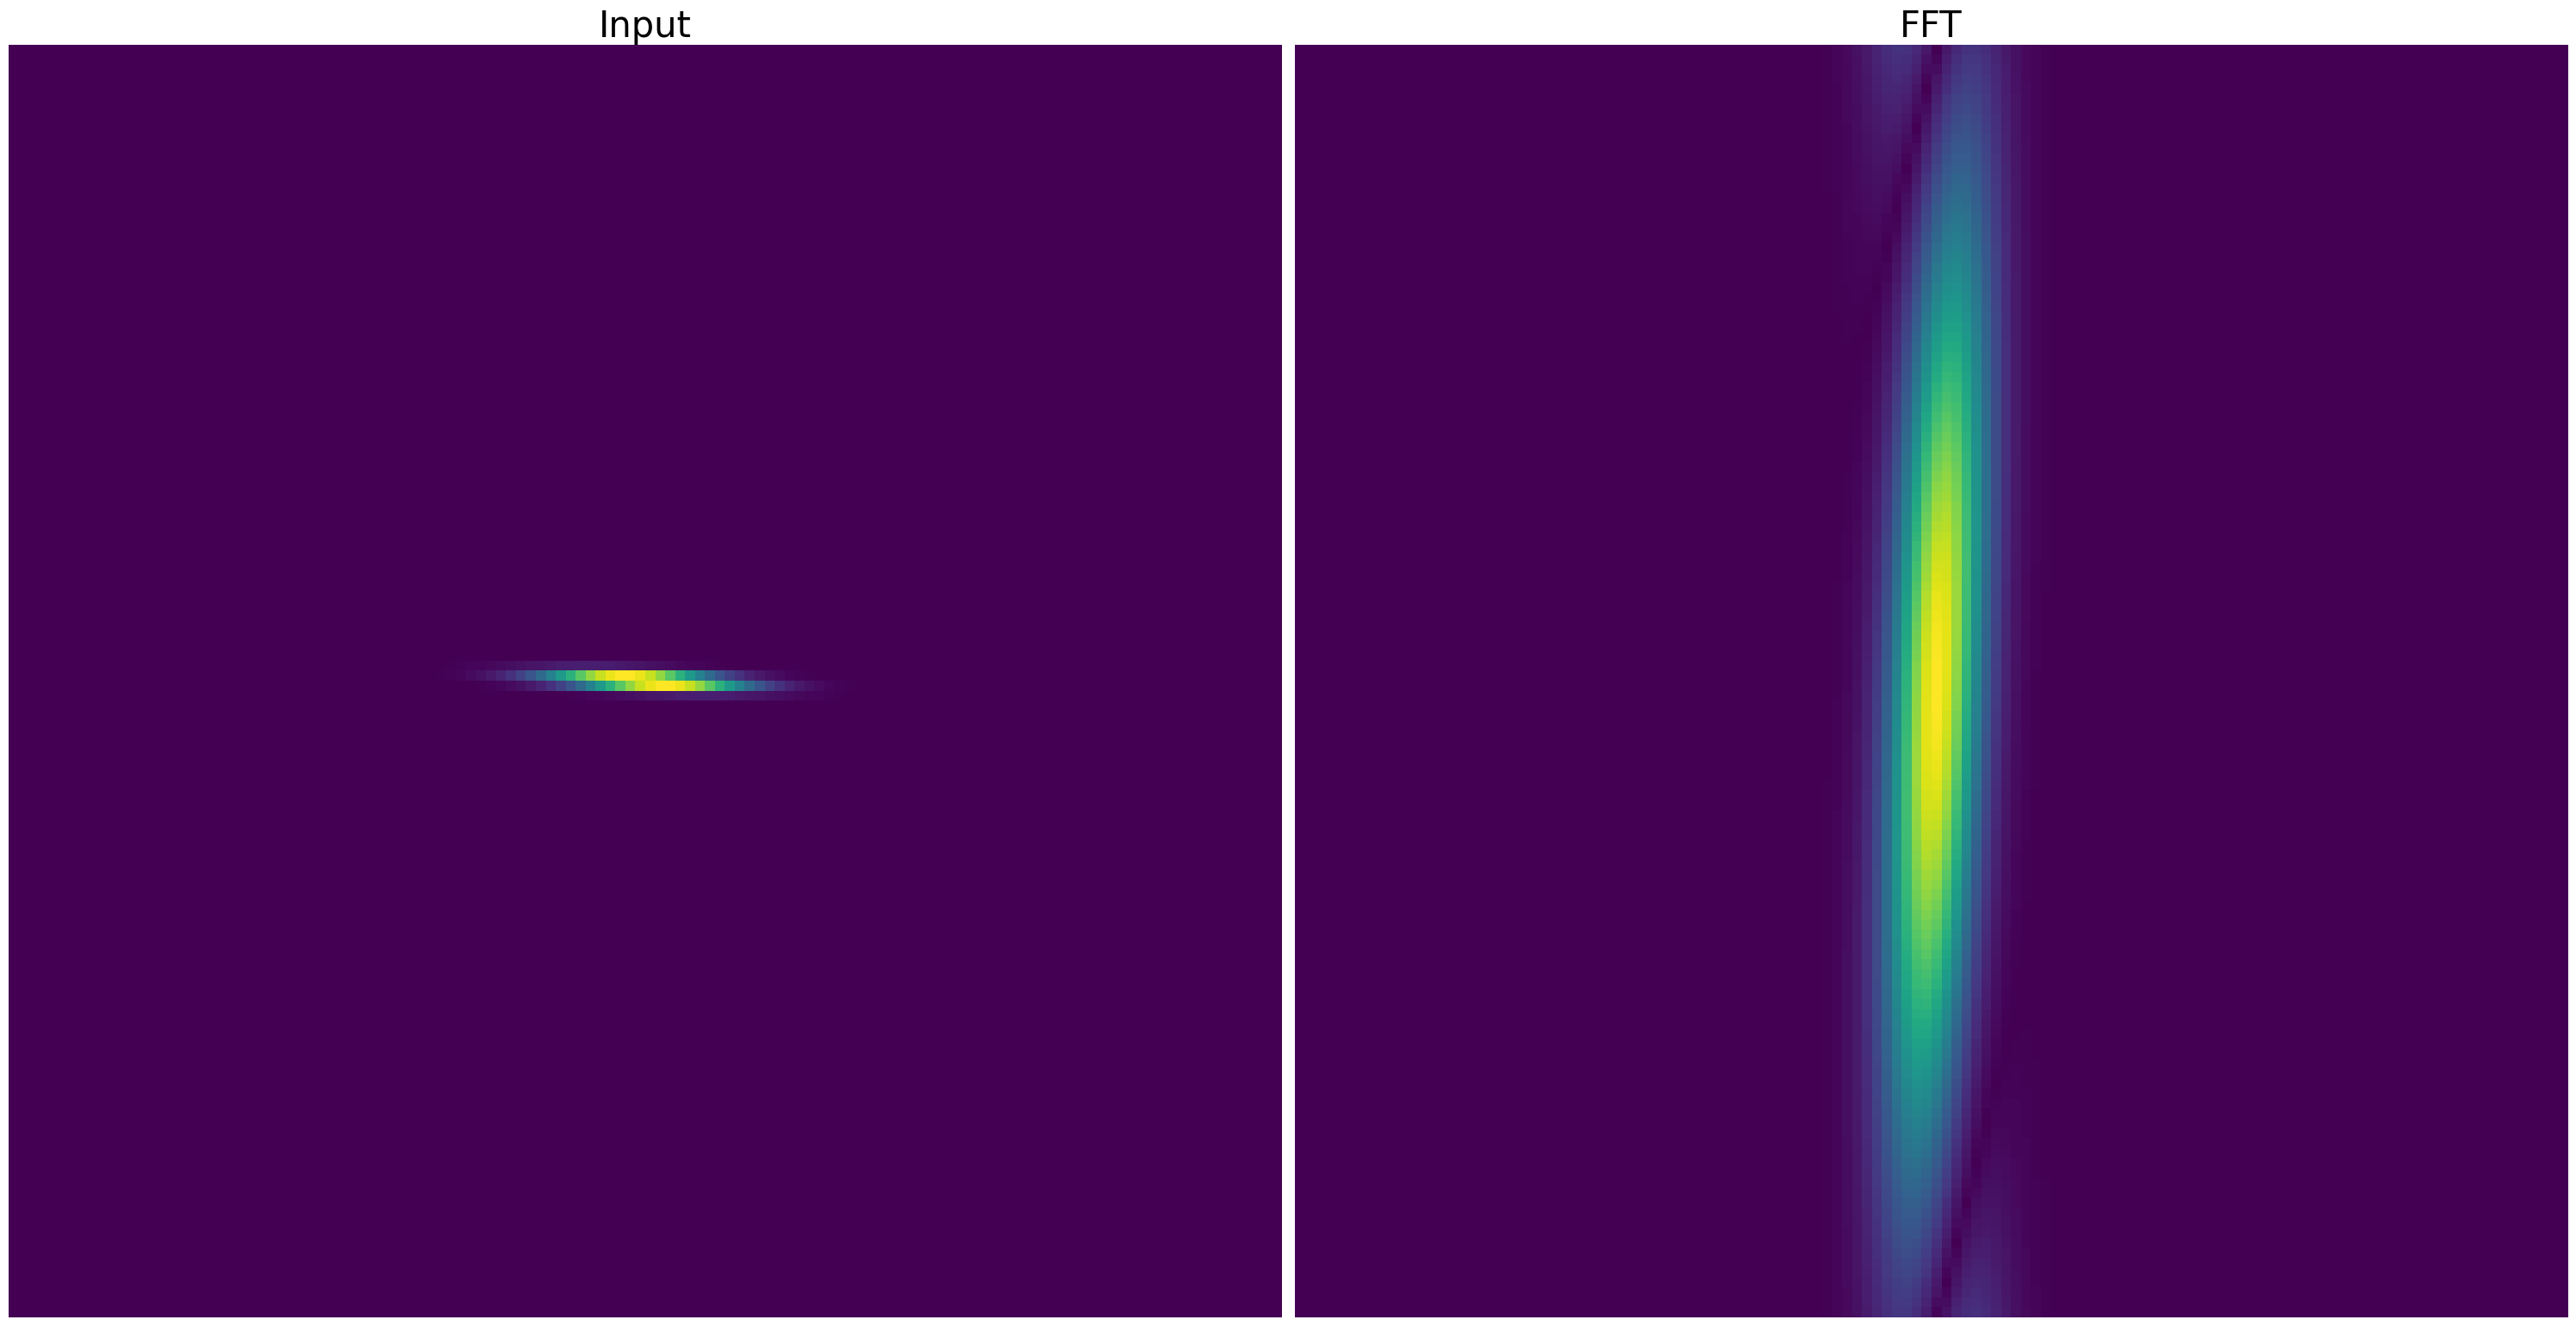

In [12]:
gauss, DFT = FT_by_hand(sigma_x=1, sigma_y=0.1, rho=0.4)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

**Large elliptical $\rightarrow$ FT into small elliptical**

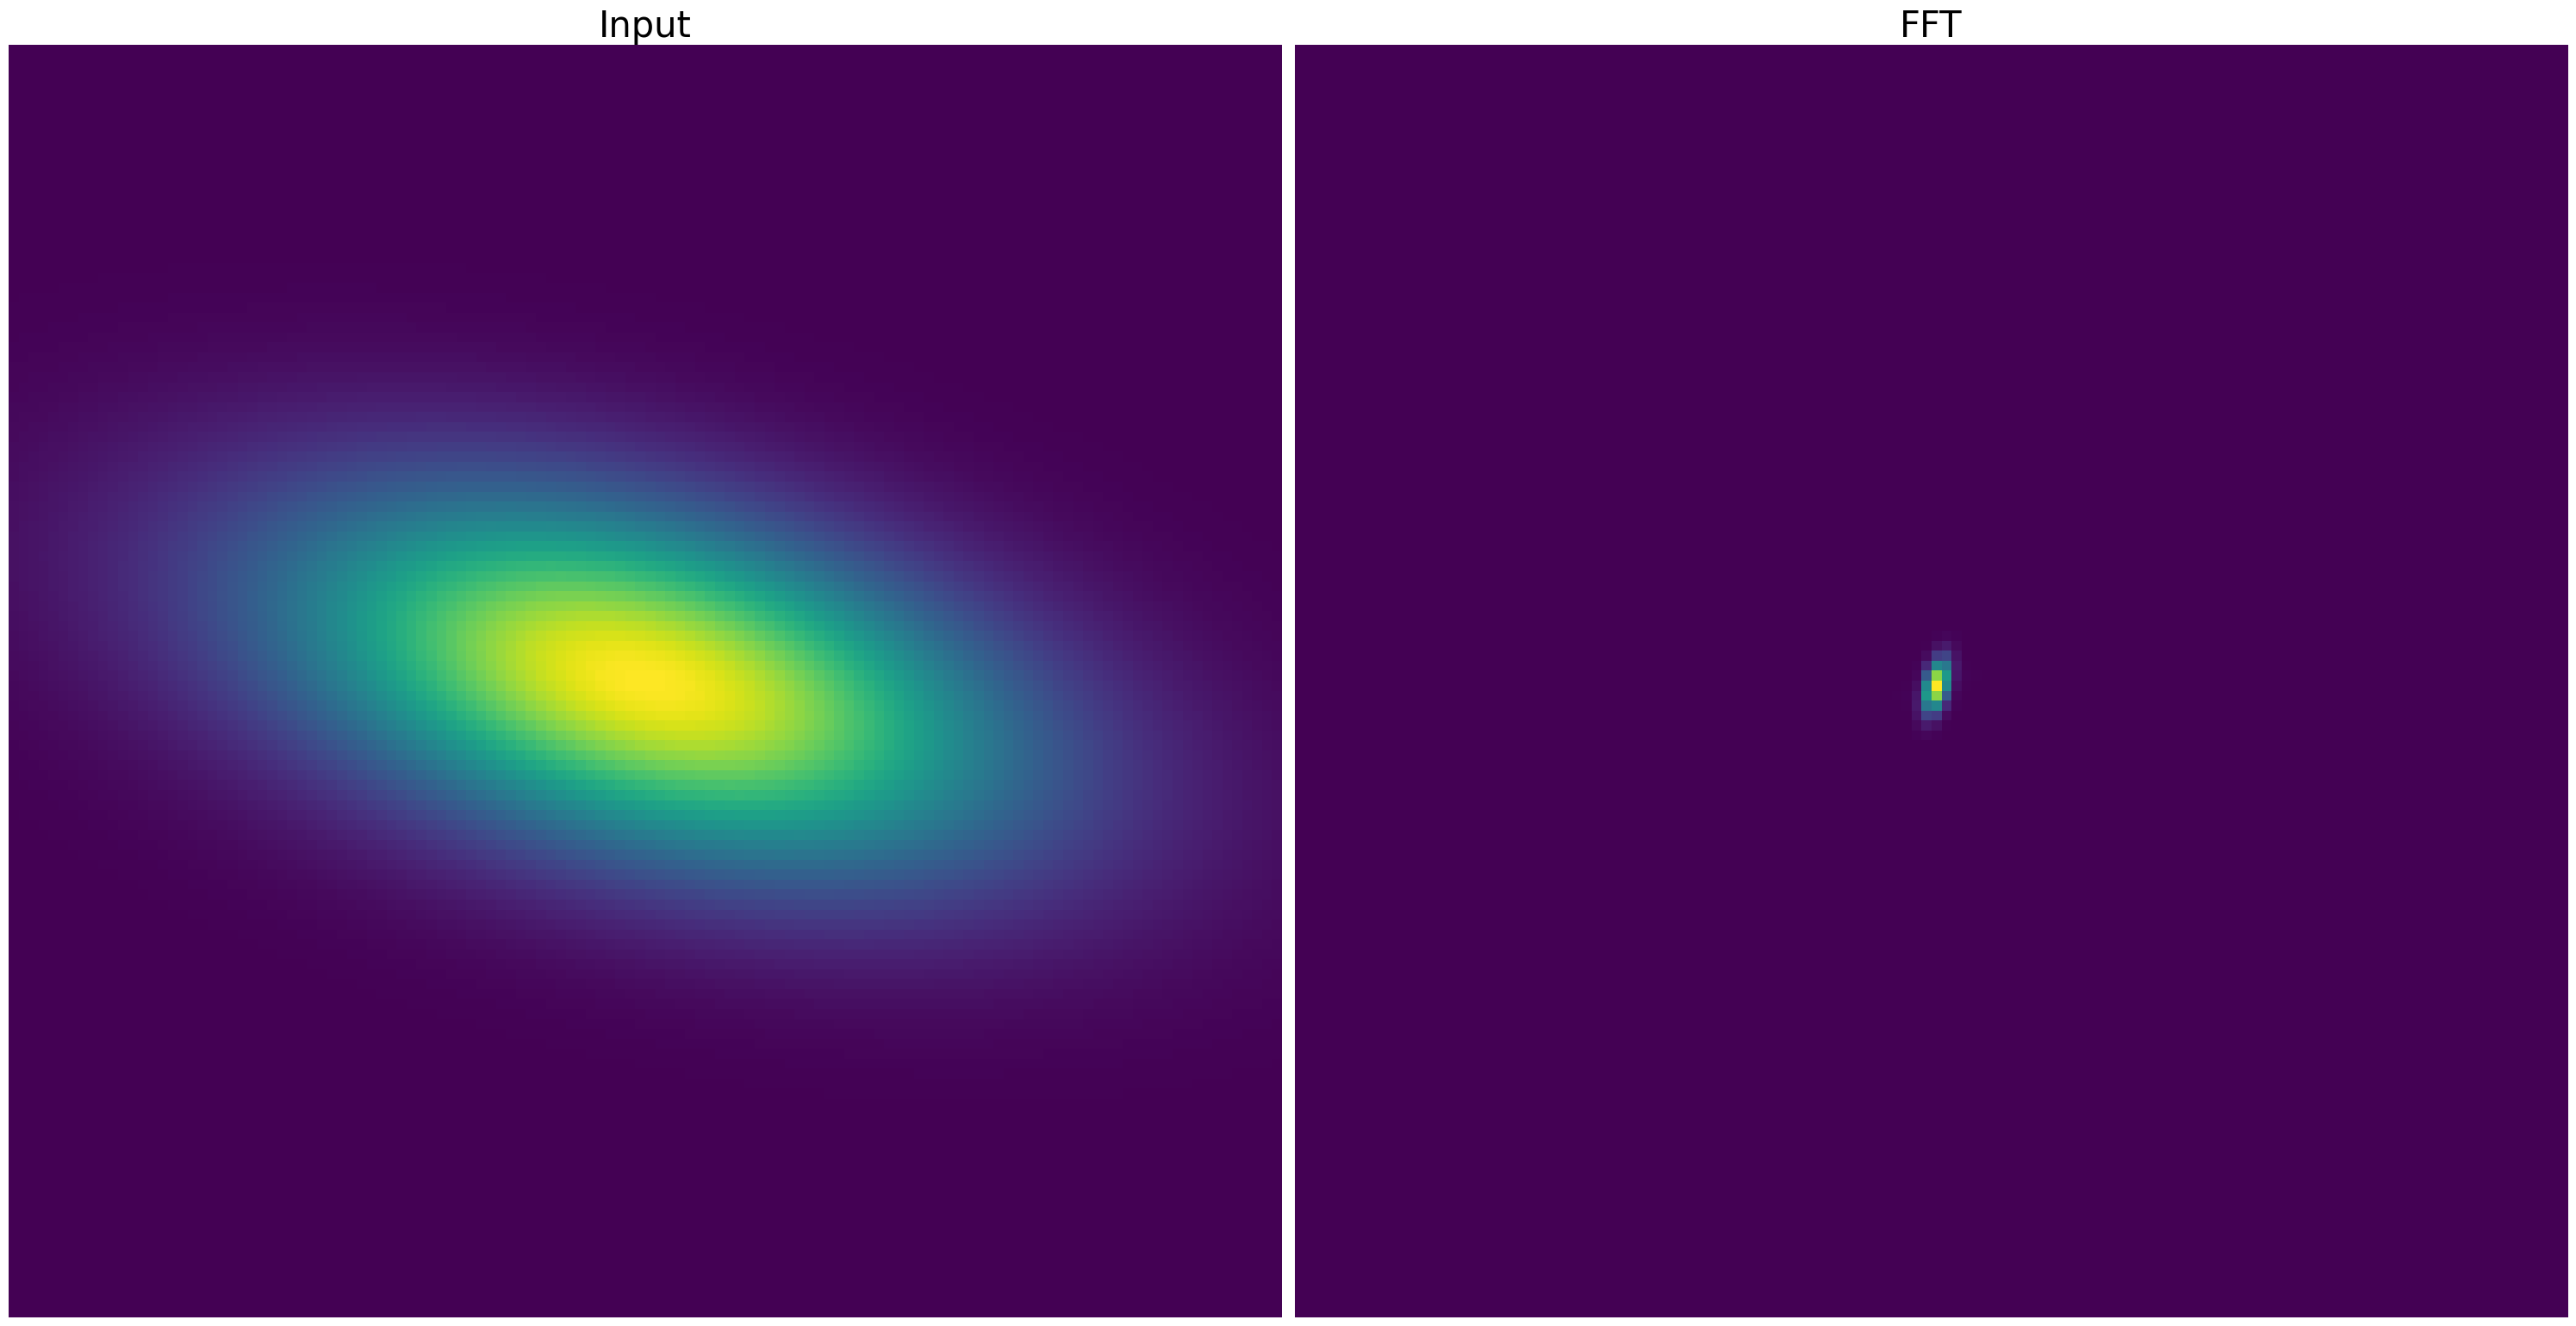

In [13]:
gauss, DFT = FT_by_hand(sigma_x=4, sigma_y=2, rho=0.4)

fig, axes = plt.subplots(1, 2, figsize=(30,26))
axes[0].imshow(gauss)
axes[0].axis('off')
axes[0].set_title('Input', fontsize=30)
axes[1].imshow(np.abs(DFT))
axes[1].axis('off')
axes[1].set_title('FFT', fontsize=30)


plt.tight_layout()
plt.show()

# 2. Gaussians using `GalSim`: Using [demo2](https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo2.py) as a guide

Using [galsim](http://galsim-developers.github.io/GalSim/_build/html/tutorials.html#demo-1) for creating the 2 2D gaussian galaxies. Check out the [galsim github](https://github.com/GalSim-developers/GalSim/tree/releases/2.4/examples) for demos of `galsim`.

In [14]:
def create_gauss_gal(gal_flux=1.e5, 
                     gal_sigma=2.0,
                     psf_sigma=1.0, 
                     pixel_scale=0.2,
                     shear_on=False,
                     g1=0.1,
                     g2=0.2,
                     noise_on=False,
                     noise=30.):
    """
    Function that creates a 2D gaussian galaxy using Galsim.
    
    Args:
    -----
        gal_flux: float
            Total counts on the image
            Defaults to 1.e5
        gal_sigma: float
            The value of sigma of the profile. Typically given in arcsec.
            Defaults to 2.0
        psf_sigma: float
            The value of sigma of the PSF profile. Typically given in arcsec.
            Defaults to 1.0
        pixel_scale: float
            The value of how many arcsec/pixel there are. 
            Defaults to 0.2
        noise: float
            Standard deviation of the counts in each pixel.
            Defaults to 30.
        noise_on: Boolean
            Toggles between having a noisy gaussian image or noise-free.
            Defaults to False.
        shear_on: Boolean
            Toggles between shearing the galaxy or not. A shear is an operation
            that transforms a circle into anellipsde with minor-to-major axis
            ratio b/a, with position angle beta, while conserving the area. There
            are multiple ways to define shear, but the version we used is called
            the reduced shear ie:
            
                g1 = |g| cos(2*beta)
                g2 = |g| sin(2*beta)
               |g| = (a-b)/(a+b)
                 g = |g| exp(2i*beta)
            
            Taken as imaginary and real parts, the real part (g1) of the complex
            ellipticity describes the elongation along the coordiante axes, while
            the imaginary part (g2) describes the elongation at 45° from the axes.
        g1: float
            The first reduced shear component that describes the elongation along 
            the coordinate axes. 
            Defaults to 0.1.
        g2: float
            The second reduced shear component that describes the elongation at 45°
            from the coordinate axes.
            Defaults to 0.2
            
    Returns:
        gal: np.ndarray
            The constructed gaussian galaxy image.
            
    """
    # Define the galaxy profile
    gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
    # Shear the galaxy by some value.
    # There are quite a few ways you can use to specify a shape.
    # q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
    # e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
    # g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
    # eta, beta    Conformal shear and position angle: eta = ln(1/q)
    # e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
    # g1,g2        ("Reduced") shear components: g1 = |g| cos(2 beta), g2 = |g| sin(2 beta)
    # eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
    if shear_on == True:  
        gal = gal.shear(g1=g1, g2=g2)
    else:
        pass

    # Define the PSF profile
    psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1

    # Final profile is the convolution of these
    # Can include any number of things in the list, all of which are convolved
    # together to make the final flux profile.
    final = galsim.Convolve([gal, psf])

    # Draw the image with a particular pixel scale, given in arcsec/pixel.
    # The returned image has a member, added_flux, which is gives the total flux actually added to
    # the image.  One could use this value to check if the image is large enough for some desired
    # accuracy level.  Here, we just ignore it.
    image = final.drawImage(scale=pixel_scale, nx=128, ny=128)

    # Add Gaussian noise to the image with specified sigma
    if noise_on == True:
        image.addNoise(galsim.GaussianNoise(sigma=noise))
        return image.array
    else:
        return image.array
    
def visualize_FT(img):
    
    f, fshift, mag = FFT_IFFT_calc(img=img, FFT=True)
    ifft = FFT_IFFT_calc(img=fshift, FFT=False)
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input', fontsize=30)
    axes[1].imshow(mag)
    axes[1].axis('off')
    axes[1].set_title('FFT', fontsize=30)
    axes[2].imshow(ifft.real)
    axes[2].axis('off')
    axes[2].set_title('IFFT(FFT(Input))', fontsize=30)
   

    plt.tight_layout()
    plt.show()

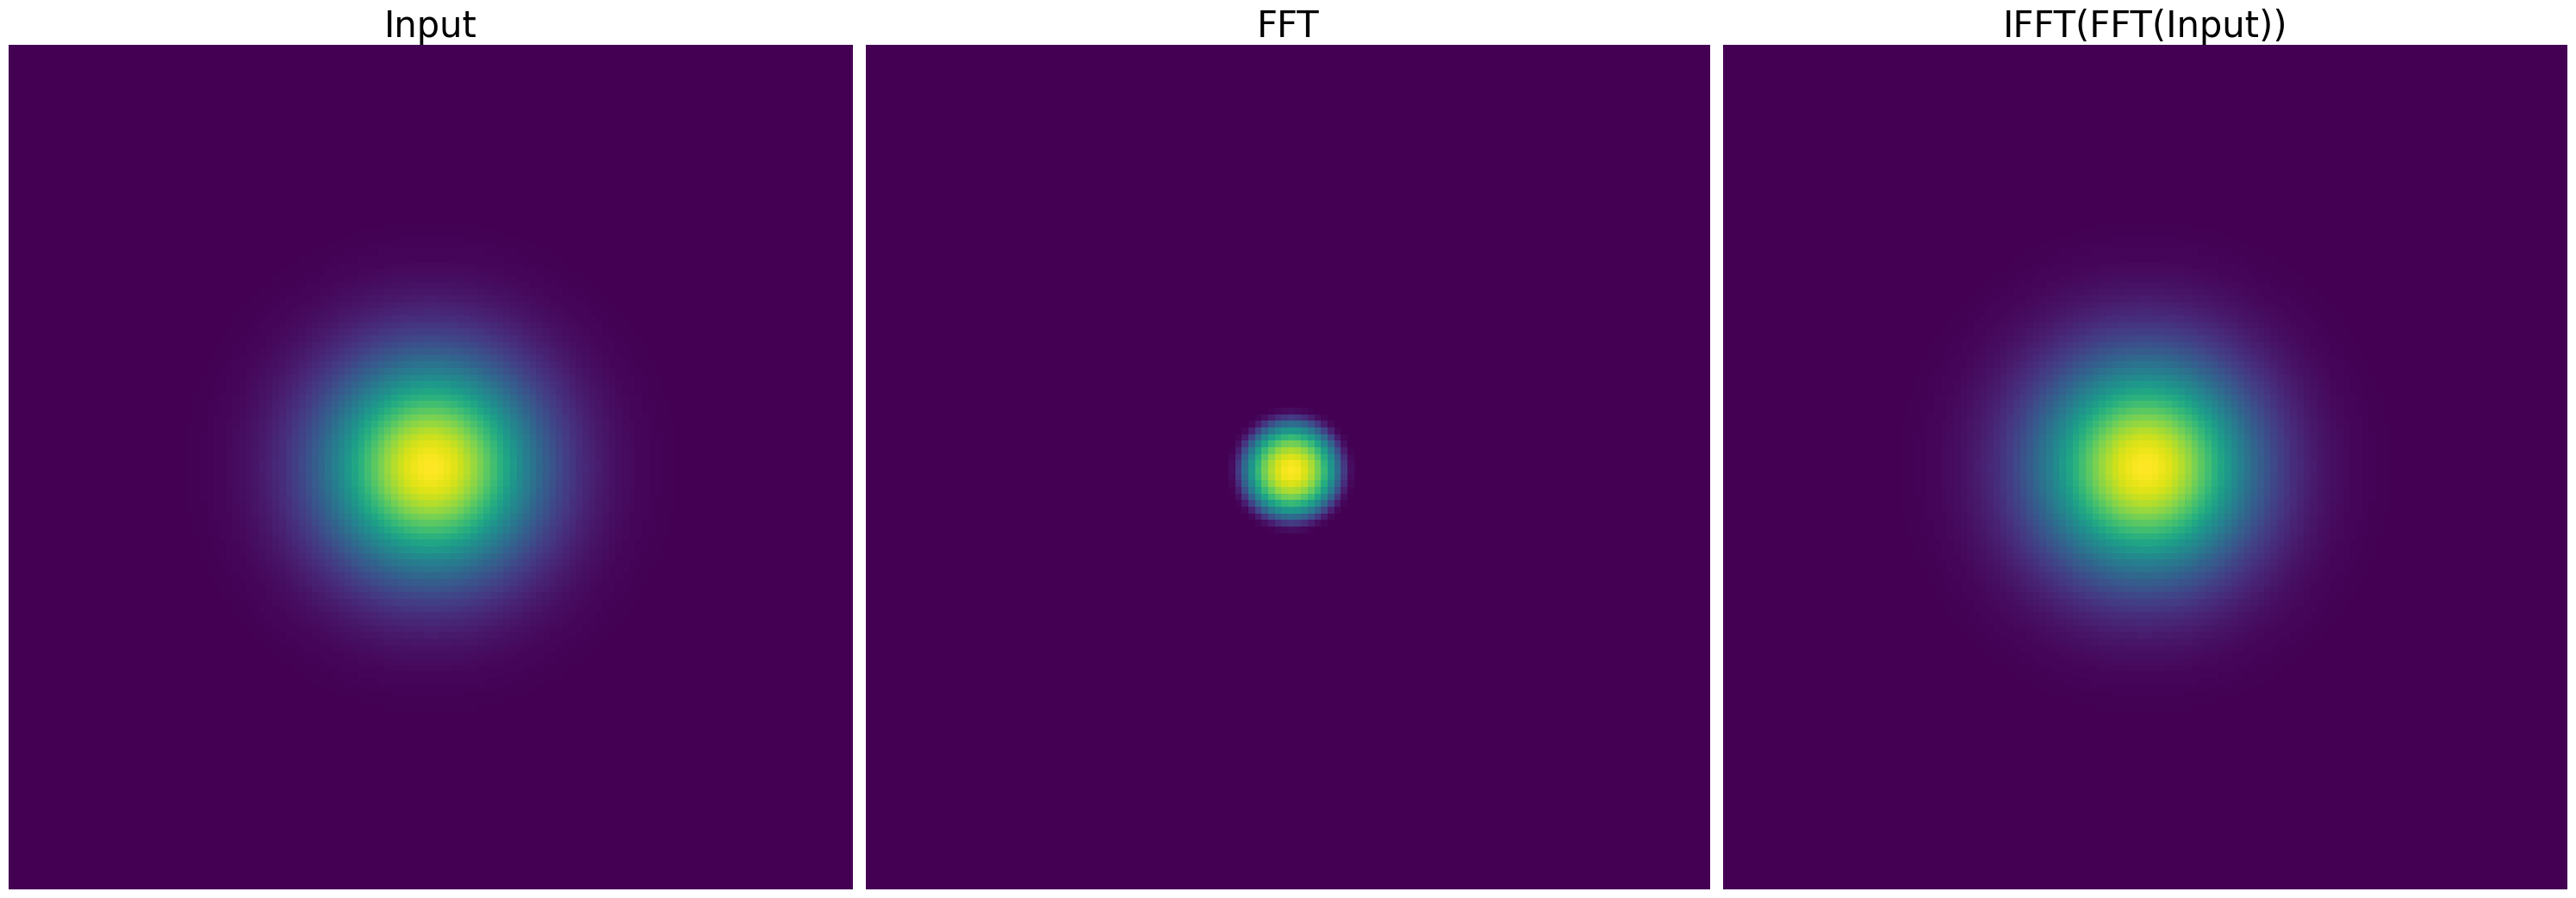

In [15]:
# Acts as the pre-sheared galaxy
round_gauss = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2)
visualize_FT(round_gauss)

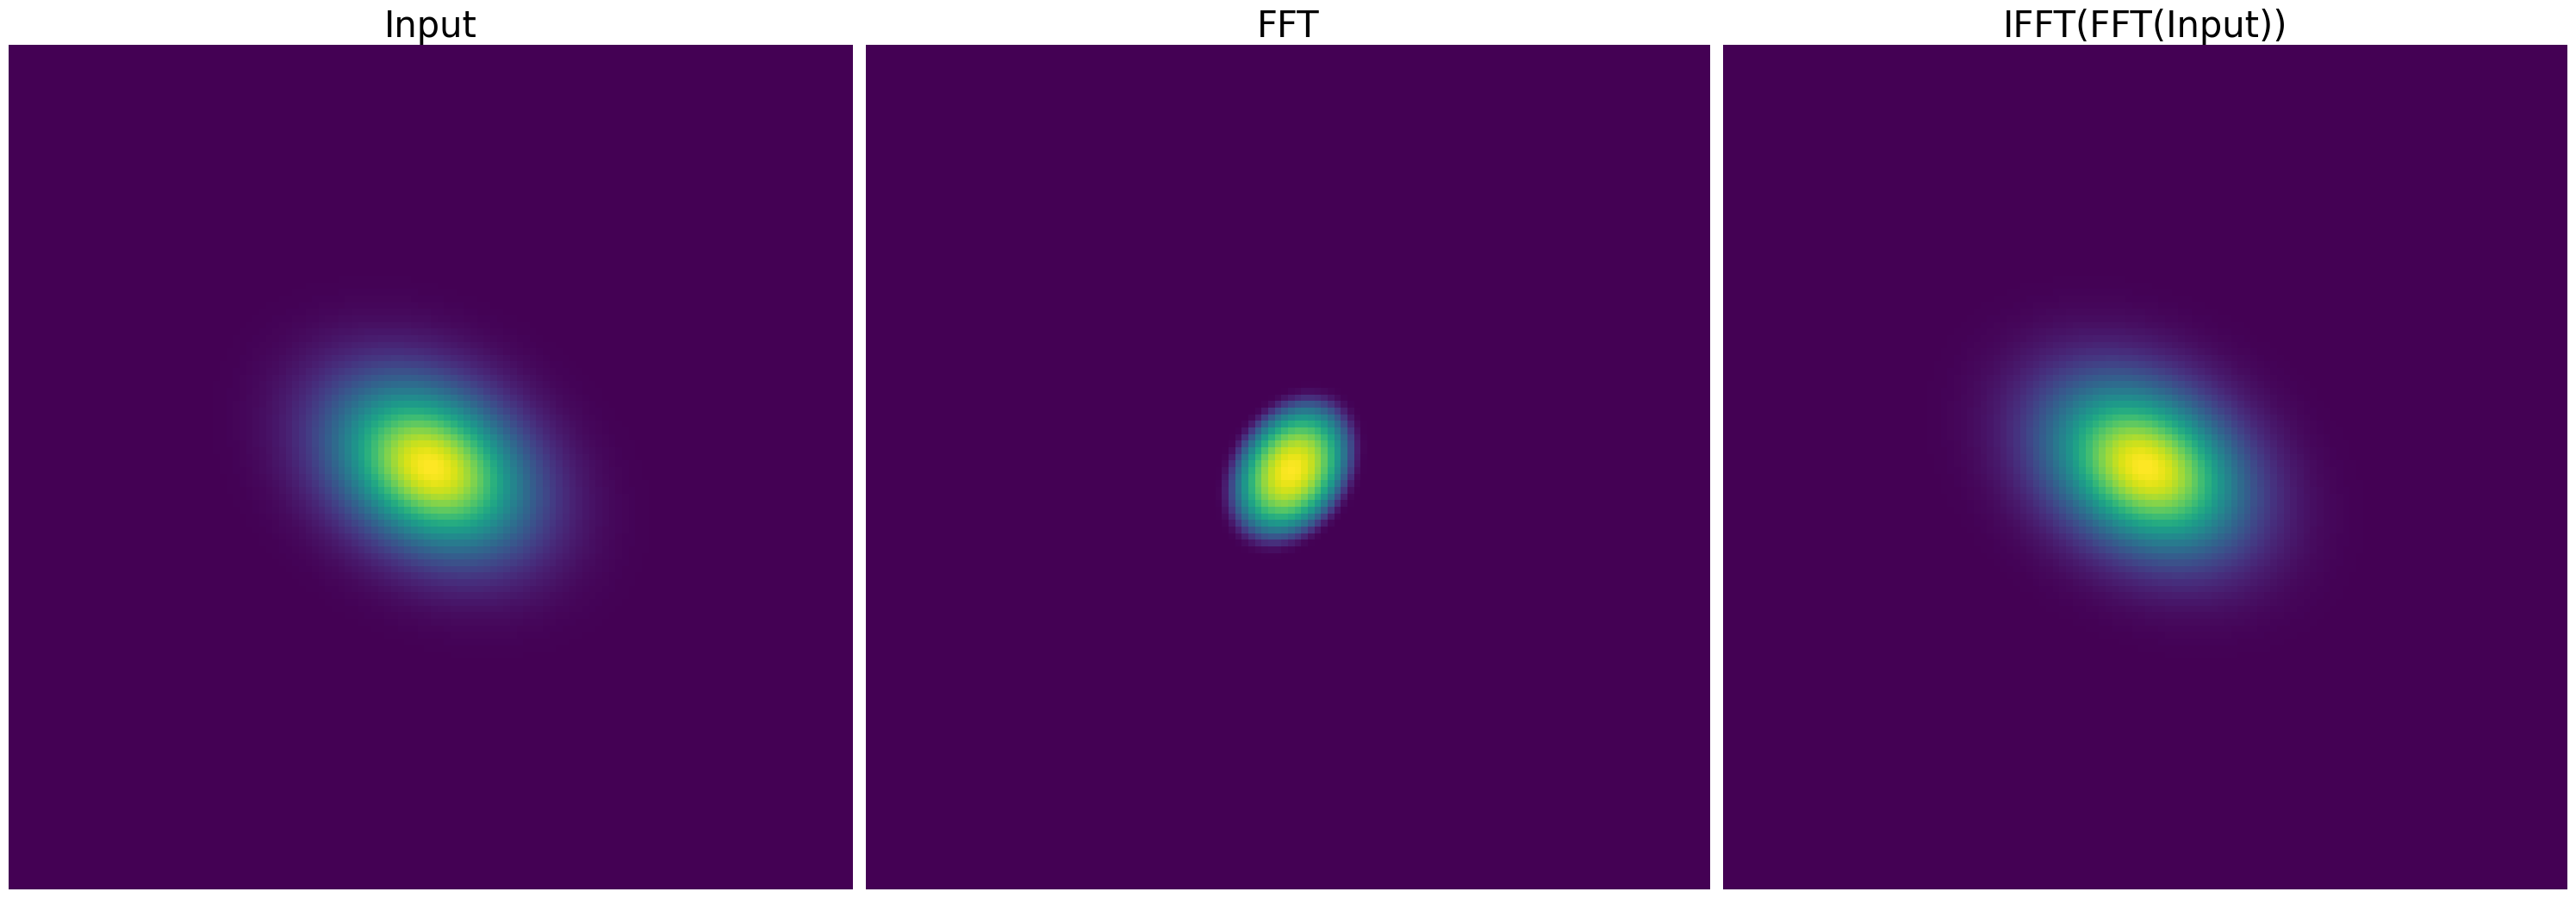

In [16]:
post_shear = create_gauss_gal(gal_flux=1.e5, 
                               gal_sigma=1.5,
                               psf_sigma=1.0, 
                               pixel_scale=0.2,
                               shear_on=True,
                               g1=0.1,
                               g2=0.2)
visualize_FT(post_shear)

So from doing the 2D FT Transform by hand we see the main points ie.:
1. The FT of a Gaussian is a Gaussian of reciprocal width. Meaning that if the input Gaussian is really spread out the FFT Gaussian will be really narrow and vice versa.
2. The flipping of the data in FT.

# 3. Noise effects of on Gaussians

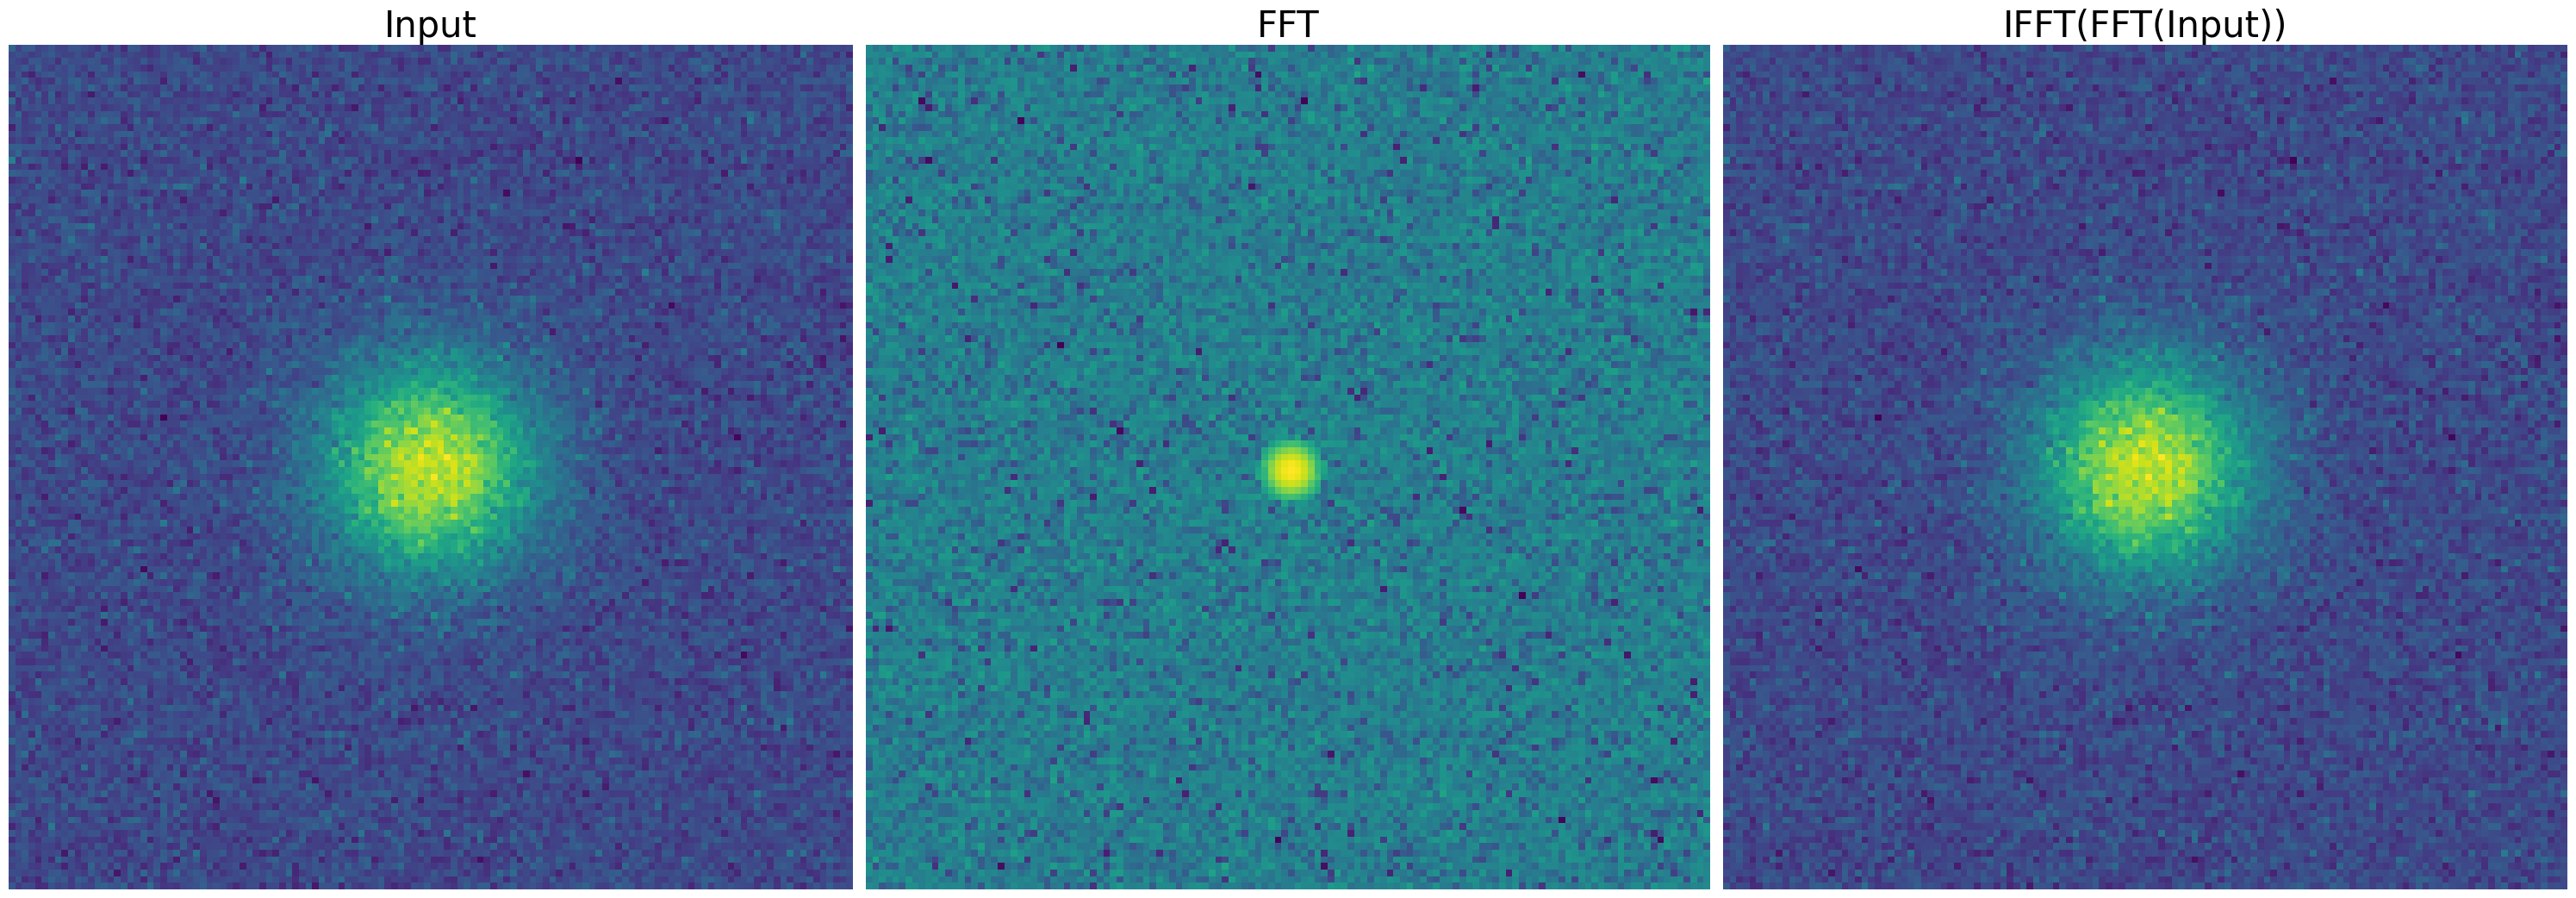

In [17]:
# Acts as the pre-sheared galaxy
round_noisy_gauss = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2,
                                   noise=10.,
                                   noise_on=True)
visualize_FT(round_noisy_gauss)

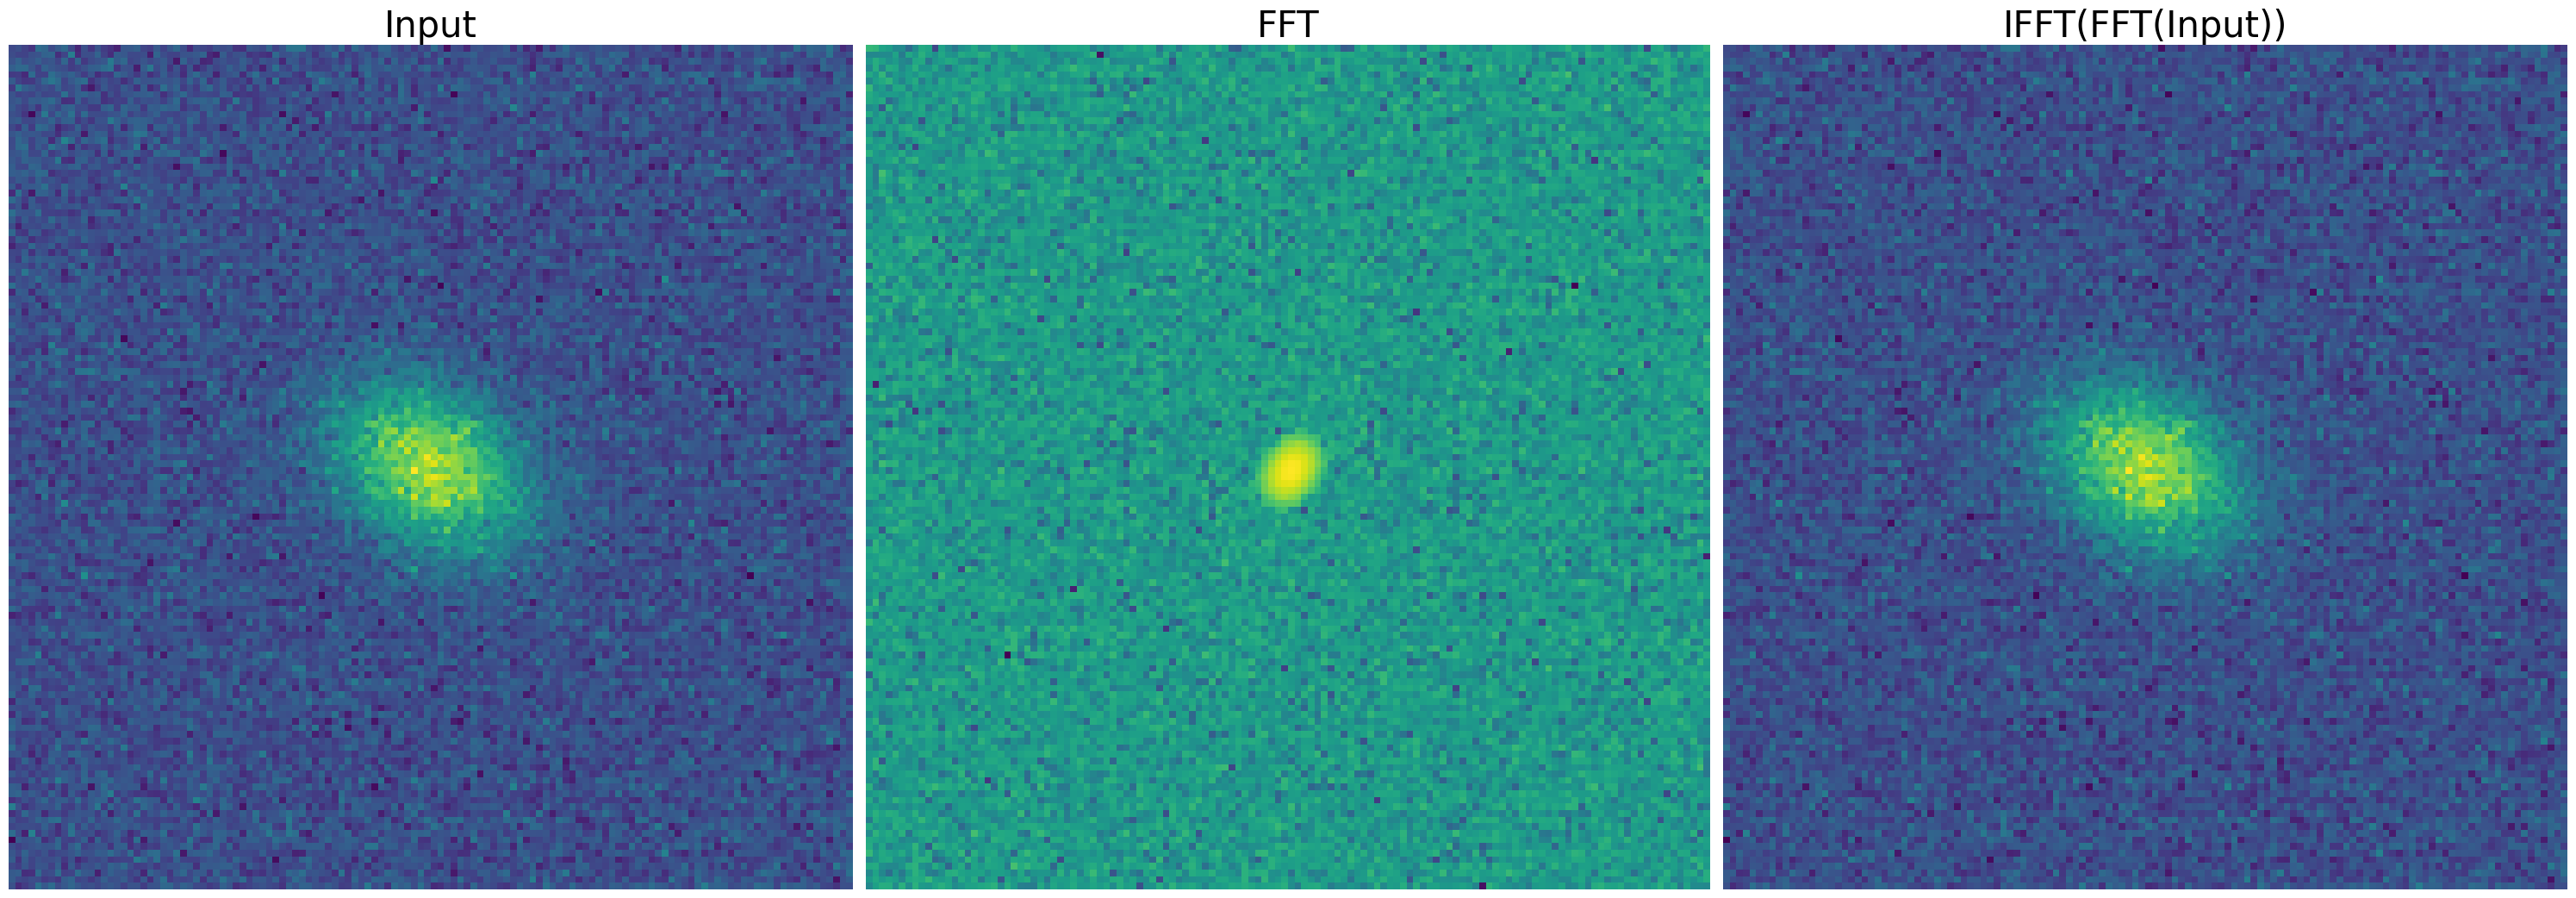

In [18]:
post_noisy_shear = create_gauss_gal(gal_flux=1.e5, 
                               gal_sigma=1.5,
                               psf_sigma=1.0, 
                               pixel_scale=0.2,
                               shear_on=True,
                               g1=0.1,
                               g2=0.2,
                               noise=20.,
                               noise_on=True)
visualize_FT(post_noisy_shear)